# 0. DATA - bags-of-lies

## load end unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/BagOfLies.zip'
extract_path = '/content/bag_of_lies'
password = 'L-1-#$_&L0G123'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.setpassword(password.encode('utf-8'))
    zip_ref.extractall(extract_path)

In [ ]:
import os
import pandas as pd
import numpy as np


# Paths
base_path = '/content/bag_of_lies/BagOfLies'
dataset_root = os.path.join(base_path, 'Finalised')
annotations_path = os.path.join(base_path, 'Annotations.csv')

print("="*60)
print(" BAG-OF-LIES DATASET EXPLORATION")
print("="*60)

# 1. CHECK ANNOTATIONS
print("\n ANNOTATIONS FILE:")
if os.path.exists(annotations_path):
    df = pd.read_csv(annotations_path)
    print(f"    Found: {annotations_path}")
    print(f"   Total samples: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"\n   Label distribution:")
    print(f"   - Truthful (1): {(df['truth']==1).sum()}")
    print(f"   - Deceptive (0): {(df['truth']==0).sum()}")
else:
    print(f"    Not found at: {annotations_path}")

# 2. COUNT USERS
print("\n USERS:")
users = sorted([d for d in os.listdir(dataset_root) if d.startswith('User_')])
print(f"   Total users: {len(users)}")
print(f"   Range: {users[0]} to {users[-1]}")

# 3. COUNT RUNS PER USER
print("\n RUNS PER USER:")
total_runs = 0
runs_per_user = {}

for user in users:
    user_path = os.path.join(dataset_root, user)
    runs = sorted([d for d in os.listdir(user_path) if d.startswith('run_')])
    runs_per_user[user] = len(runs)
    total_runs += len(runs)

print(f"   Total runs: {total_runs}")
print(f"   Average runs per user: {total_runs/len(users):.1f}")
print(f"\n   First 10 users:")
for user in users[:10]:
    print(f"   - {user}: {runs_per_user[user]} runs")

# 4. CHECK FILES IN A SAMPLE RUN
print("\n SAMPLE RUN (User_0/run_0):")
sample_run = os.path.join(dataset_root, 'User_0/run_0')
if os.path.exists(sample_run):
    files = os.listdir(sample_run)
    print(f"   Files in run:")
    for f in sorted(files):
        file_path = os.path.join(sample_run, f)
        size = os.path.getsize(file_path) / (1024*1024)  # MB
        print(f"   - {f:15s} ({size:.2f} MB)")
else:
    print(f"    Not found")

# 5. SUMMARY
print("\n" + "="*60)
print(" SUMMARY:")
print("="*60)
print(f"   Users: {len(users)}")
print(f"   Total runs: {total_runs}")
print(f"   Total samples: {len(df)}")
print(f"   Truthful: {(df['truth']==1).sum()}")
print(f"   Deceptive: {(df['truth']==0).sum()}")
print(f"\n   Expected: 35 users, 325 runs")
if len(users) == 35 and total_runs == 325:
    print("    PERFECT MATCH!")
else:
    print(f"     Mismatch - verify data")

# Save paths for later
DATASET_ROOT = dataset_root
ANNOTATIONS_PATH = annotations_path
print(f"\n Paths saved:")
print(f"   DATASET_ROOT = '{DATASET_ROOT}'")
print(f"   ANNOTATIONS_PATH = '{ANNOTATIONS_PATH}'")

 BAG-OF-LIES DATASET EXPLORATION

 ANNOTATIONS FILE:
    Found: /content/bag_of_lies/BagOfLies/Annotations.csv
   Total samples: 325
   Columns: ['eeg', 'gaze', 'image', 'run', 'truth', 'usernum', 'video']

   Label distribution:
   - Truthful (1): 163
   - Deceptive (0): 162

 USERS:
   Total users: 35
   Range: User_0 to User_9

 RUNS PER USER:
   Total runs: 325
   Average runs per user: 9.3

   First 10 users:
   - User_0: 6 runs
   - User_1: 6 runs
   - User_10: 9 runs
   - User_11: 10 runs
   - User_12: 10 runs
   - User_13: 10 runs
   - User_14: 10 runs
   - User_15: 10 runs
   - User_16: 10 runs
   - User_17: 10 runs

 SAMPLE RUN (User_0/run_0):
   Files in run:
   - EEG.csv         (0.23 MB)
   - Gaze.csv        (0.16 MB)
   - image.jpg       (2.53 MB)
   - video.mp4       (1.58 MB)

 SUMMARY:
   Users: 35
   Total runs: 325
   Total samples: 325
   Truthful: 163
   Deceptive: 162

   Expected: 35 users, 325 runs
    PERFECT MATCH!

 Paths saved:
   DATASET_ROOT = '/content/ba

## extract video and audio fearure and save in drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import librosa
from moviepy.editor import VideoFileClip
from skimage.feature import local_binary_pattern
import tempfile
from tqdm import tqdm

# =========================
# CONFIGURATION
# =========================

DATASET_ROOT = '/content/bag_of_lies/BagOfLies/Finalised'
ANNOTATIONS_PATH = '/content/bag_of_lies/BagOfLies/Annotations.csv'
FEATURES_DIR = '/content/drive/MyDrive/BagOfLies_Features'
CHECKPOINT_EVERY = 25  # Save every 25 videos
MAX_FRAMES = 150  # Pad/truncate to this length

os.makedirs(FEATURES_DIR, exist_ok=True)

# =========================
# FEATURE EXTRACTION FUNCTIONS
# =========================

def extract_audio_features(video_path, n_mfcc=13, max_frames=150):
    """Extract 26-dim audio features from video"""
    try:
        # Extract audio from video
        video = VideoFileClip(video_path)

        # Create temp file
        with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
            tmp_path = tmp.name

        video.audio.write_audiofile(tmp_path, fps=22050, verbose=False, logger=None)

        # Load audio
        y, sr = librosa.load(tmp_path, sr=22050)

        # Extract MFCCs (13 features)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Extract spectral features (7 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zero_crossing = librosa.feature.zero_crossing_rate(y)

        # Extract chroma features (6 features)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Combine: 13 + 7 + 6 = 26 features
        features = np.vstack([
            mfcc,
            spectral_centroid,
            spectral_rolloff,
            spectral_bandwidth,
            zero_crossing,
            chroma
        ])  # Shape: (26, T)

        features = features.T  # Shape: (T, 26)

        # Pad or truncate to max_frames
        if features.shape[0] < max_frames:
            # Pad with zeros
            pad_width = max_frames - features.shape[0]
            features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
        else:
            # Truncate
            features = features[:max_frames, :]

        # Clean up
        os.remove(tmp_path)
        video.close()

        return features  # Shape: (150, 26)

    except Exception as e:
        print(f"     Audio extraction failed: {e}")
        # Return zeros if fails
        return np.zeros((max_frames, 26))


def extract_video_features(video_path, max_frames=150):
    """Extract LBP features from video frames"""
    try:
        cap = cv2.VideoCapture(video_path)
        features_list = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Resize for consistency
            gray = cv2.resize(gray, (128, 128))

            # Compute LBP
            lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

            # Histogram as feature
            hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
            hist = hist.astype('float32') / (hist.sum() + 1e-7)

            features_list.append(hist)

        cap.release()

        if len(features_list) == 0:
            return np.zeros((max_frames, 59))

        features = np.array(features_list)  # Shape: (T, 59)

        # Pad or truncate
        if features.shape[0] < max_frames:
            pad_width = max_frames - features.shape[0]
            features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
        else:
            features = features[:max_frames, :]

        return features  # Shape: (150, 59)

    except Exception as e:
        print(f"     Video extraction failed: {e}")
        return np.zeros((max_frames, 59))


# =========================
# MAIN EXTRACTION LOOP
# =========================

print("="*60)
print(" FEATURE EXTRACTION WITH CHECKPOINTING")
print("="*60)

# Load annotations
df = pd.read_csv(ANNOTATIONS_PATH)
print(f"\n Total samples: {len(df)}")

# Check for existing progress
CHECKPOINT_FILE = f'{FEATURES_DIR}/progress.txt'

if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE, 'r') as f:
        start_idx = int(f.read().strip())
    print(f" Resuming from sample {start_idx}/{len(df)}")

    # Load partial results
    audio_features = np.load(f'{FEATURES_DIR}/audio_features_partial.npy').tolist()
    video_features = np.load(f'{FEATURES_DIR}/video_features_partial.npy').tolist()
    labels = np.load(f'{FEATURES_DIR}/labels_partial.npy').tolist()
else:
    start_idx = 0
    audio_features = []
    video_features = []
    labels = []
    print("🆕 Starting fresh extraction")

print(f"\n Estimated time: ~{(len(df)-start_idx)*7/60:.0f} minutes")
print(" Checkpoints will be saved to Drive every 25 videos\n")

# Extract features
for idx in range(start_idx, len(df)):
    row = df.iloc[idx]

    # Build video path
    video_rel_path = row['video'].replace('./', '')
    video_path = os.path.join('/content/bag_of_lies/BagOfLies', video_rel_path)

    print(f"[{idx+1}/{len(df)}] User_{row['usernum']}/run_{row['run']} ", end='')

    if not os.path.exists(video_path):
        print(" Video not found")
        # Use zeros for missing video
        audio_features.append(np.zeros((MAX_FRAMES, 26)))
        video_features.append(np.zeros((MAX_FRAMES, 59)))
        labels.append(row['truth'])
        continue

    try:
        # Extract
        audio_feat = extract_audio_features(video_path, max_frames=MAX_FRAMES)
        video_feat = extract_video_features(video_path, max_frames=MAX_FRAMES)

        audio_features.append(audio_feat)
        video_features.append(video_feat)
        labels.append(row['truth'])

        print("OK")

        # CHECKPOINT
        if (idx + 1) % CHECKPOINT_EVERY == 0:
            print(f"\n Checkpoint at {idx+1}/{len(df)}...")

            np.save(f'{FEATURES_DIR}/audio_features_partial.npy',
                   np.array(audio_features))
            np.save(f'{FEATURES_DIR}/video_features_partial.npy',
                   np.array(video_features))
            np.save(f'{FEATURES_DIR}/labels_partial.npy',
                   np.array(labels))

            with open(CHECKPOINT_FILE, 'w') as f:
                f.write(str(idx + 1))

            print(f" Progress saved to Drive\n")

    except Exception as e:
        print(f" Error: {e}")
        # Use zeros for failed extraction
        audio_features.append(np.zeros((MAX_FRAMES, 26)))
        video_features.append(np.zeros((MAX_FRAMES, 59)))
        labels.append(row['truth'])

# =========================
# FINAL SAVE
# =========================

print("\n" + "="*60)
print(" SAVING FINAL FEATURES")
print("="*60)

audio_features = np.array(audio_features)  # Shape: (325, 150, 26)
video_features = np.array(video_features)  # Shape: (325, 150, 59)
labels = np.array(labels)  # Shape: (325,)

print(f"\nFinal shapes:")
print(f"  Audio: {audio_features.shape}")
print(f"  Video: {video_features.shape}")
print(f"  Labels: {labels.shape}")

# Save final files
np.save(f'{FEATURES_DIR}/audio_features.npy', audio_features)
np.save(f'{FEATURES_DIR}/video_features.npy', video_features)
np.save(f'{FEATURES_DIR}/labels.npy', labels)

# Save metadata
metadata = {
    'num_samples': len(labels),
    'max_frames': MAX_FRAMES,
    'audio_dim': 26,
    'video_dim': 59,
    'truthful': int((labels==1).sum()),
    'deceptive': int((labels==0).sum())
}

import json
with open(f'{FEATURES_DIR}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Clean up checkpoint files
for f in ['audio_features_partial.npy', 'video_features_partial.npy',
          'labels_partial.npy', 'progress.txt']:
    try:
        os.remove(f'{FEATURES_DIR}/{f}')
    except:
        pass

print("\n All features saved to Drive!")
print(f" Location: {FEATURES_DIR}")
print(f" Files:")
print(f"   - audio_features.npy ({audio_features.nbytes/1024/1024:.1f} MB)")
print(f"   - video_features.npy ({video_features.nbytes/1024/1024:.1f} MB)")
print(f"   - labels.npy ({labels.nbytes/1024:.1f} KB)")
print(f"   - metadata.json")
print("\n Feature extraction complete!")

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



 FEATURE EXTRACTION WITH CHECKPOINTING

 Total samples: 325
🆕 Starting fresh extraction

 Estimated time: ~38 minutes
 Checkpoints will be saved to Drive every 25 videos

[1/325] User_0/run_0 OK
[2/325] User_0/run_1 OK
[3/325] User_0/run_2 OK
[4/325] User_0/run_3 OK
[5/325] User_0/run_4 OK
[6/325] User_0/run_5 OK
[7/325] User_1/run_0 OK
[8/325] User_1/run_1 OK
[9/325] User_1/run_2 OK
[10/325] User_1/run_3 OK
[11/325] User_1/run_4 OK
[12/325] User_1/run_5 OK
[13/325] User_2/run_0 OK
[14/325] User_2/run_1 OK
[15/325] User_2/run_2 OK
[16/325] User_3/run_0 OK
[17/325] User_3/run_1 OK
[18/325] User_3/run_2 OK
[19/325] User_3/run_3 OK
[20/325] User_3/run_4 OK
[21/325] User_3/run_5 OK
[22/325] User_3/run_6 OK
[23/325] User_3/run_7 OK
[24/325] User_4/run_0 OK
[25/325] User_4/run_1 OK

 Checkpoint at 25/325...
 Progress saved to Drive

[26/325] User_4/run_2 OK
[27/325] User_4/run_3 OK
[28/325] User_4/run_4 OK
[29/325] User_4/run_5 OK
[30/325] User_4/run_6 OK
[31/325] User_4/run_7 OK
[32/325] Us

# Models 1.0 -> raw features

In [ ]:
!pip install moviepy librosa scikit-image scipy -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os


In [ ]:
# ============================================
# STEP 0: CHECK GPU
# ============================================

print("="*60)
print(" ENVIRONMENT SETUP")
print("="*60)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("    No GPU available - training will be slow!")


 ENVIRONMENT SETUP

 Device: cuda
   GPU: Tesla T4
   Memory: 14.7 GB


In [ ]:
# ============================================
# STEP 1: LOAD DATA
# ============================================

# from google.colab import drive
# drive.mount('/content/drive')

# Paths
FEATURES_DIR = '/content/drive/MyDrive/BagOfLies_Features'
RESULTS_DIR = '/content/drive/MyDrive/BagOfLies_Results'
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"\n Directories:")
print(f"   Features: {FEATURES_DIR}")
print(f"   Results: {RESULTS_DIR}")

# Load features
print(f"\n Loading features...")
audio_features = np.load(f'{FEATURES_DIR}/audio_features.npy')
video_features = np.load(f'{FEATURES_DIR}/video_features.npy')
labels = np.load(f'{FEATURES_DIR}/labels.npy')

print(f" Loaded:")
print(f"   Audio: {audio_features.shape}")
print(f"   Video: {video_features.shape}")
print(f"   Labels: {labels.shape}")
print(f"   Balance: {(labels==1).sum()} truthful, {(labels==0).sum()} deceptive")

# Load annotations to get user IDs
ANNOTATIONS_PATH = '/content/bag_of_lies/BagOfLies/Annotations.csv'
df = pd.read_csv(ANNOTATIONS_PATH)
user_ids = df['usernum'].values

print(f"   Users: {len(np.unique(user_ids))} unique")
print("\n Setup complete!")



 Directories:
   Features: /content/drive/MyDrive/BagOfLies_Features
   Results: /content/drive/MyDrive/BagOfLies_Results

 Loading features...
 Loaded:
   Audio: (325, 150, 29)
   Video: (325, 150, 59)
   Labels: (325,)
   Balance: 163 truthful, 162 deceptive
   Users: 35 unique

 Setup complete!


In [ ]:
# ============================================
# CHUNK 2: HYPERPARAMETERS (according to our table 3)
# ============================================

print("="*60)
print("  HYPERPARAMETERS (From Paper Table 3)")
print("="*60)

class Config:
    # Model architecture
    lstm_hidden_dim = 64
    attention_hidden_dim = 32
    dropout_rate = 0.3

    # Training
    batch_size = 16
    learning_rate = 5e-4
    max_epochs = 100
    early_stopping_patience = 10

    # Data
    max_frames = 150
    audio_dim = 29
    video_dim = 59
    num_classes = 2

    # Cross-validation
    n_folds = 5
    random_seed = 42

    # Device
    device = device

config = Config()

# Print config
print("\n Model Configuration:")
for key, value in vars(config).items():
    if not key.startswith('_'):
        print(f"   {key:25s} = {value}")

print("\n Configuration set!")


  HYPERPARAMETERS (From Paper Table 3)

 Model Configuration:

 Configuration set!


In [ ]:
# ============================================
# STEP 3: DATASET CLASS
# ============================================

class BagOfLiesDataset(Dataset):
    """Dataset for Bag-of-Lies with audio and video features"""

    def __init__(self, audio_features, video_features, labels, indices=None):
        """
        Args:
            audio_features: (N, T, 26) numpy array
            video_features: (N, T, 59) numpy array
            labels: (N,) numpy array
            indices: Optional list of indices to use (for train/test split)
        """
        if indices is not None:
            self.audio = audio_features[indices]
            self.video = video_features[indices]
            self.labels = labels[indices]
        else:
            self.audio = audio_features
            self.video = video_features
            self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'audio': torch.FloatTensor(self.audio[idx]),
            'video': torch.FloatTensor(self.video[idx]),
            'label': torch.LongTensor([self.labels[idx]])[0]
        }

print(" Dataset class defined!")


 Dataset class defined!


In [ ]:
# ============================================
# STEP 4: MODELS ARCHITECTURES
# ============================================

class BiLSTMEncoder(nn.Module):
    """Bidirectional LSTM encoder for single modality"""

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        output, (h_n, c_n) = self.lstm(x)
        # output: (batch, seq_len, 2*hidden_dim)
        # We only use the forward direction output
        return output[:, :, :self.hidden_dim]  # (batch, seq_len, hidden_dim)


class DynamicAttentionFusion(nn.Module):
    """Dynamic attention-based fusion (Section 4.3)"""

    def __init__(self, hidden_dim, attention_dim):
        super().__init__()
        # Attention network
        self.W_att = nn.Linear(2 * hidden_dim, attention_dim)
        self.w_audio = nn.Linear(attention_dim, 1, bias=False)
        self.w_video = nn.Linear(attention_dim, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, h_audio, h_video):
        # h_audio, h_video: (batch, seq_len, hidden_dim)
        batch_size, seq_len, hidden_dim = h_audio.shape

        # Concatenate modalities
        u = torch.cat([h_audio, h_video], dim=-1)  # (batch, seq_len, 2*hidden_dim)

        # Attention network
        e = self.tanh(self.W_att(u))  # (batch, seq_len, attention_dim)

        # Modality-specific scores
        s_audio = self.w_audio(e).squeeze(-1)  # (batch, seq_len)
        s_video = self.w_video(e).squeeze(-1)  # (batch, seq_len)

        # Softmax over modalities
        scores = torch.stack([s_audio, s_video], dim=-1)  # (batch, seq_len, 2)
        alpha = torch.softmax(scores, dim=-1)  # (batch, seq_len, 2)

        alpha_audio = alpha[:, :, 0].unsqueeze(-1)  # (batch, seq_len, 1)
        alpha_video = alpha[:, :, 1].unsqueeze(-1)  # (batch, seq_len, 1)

        # Weighted fusion
        c = alpha_audio * h_audio + alpha_video * h_video  # (batch, seq_len, hidden_dim)

        return c, alpha_audio, alpha_video


In [ ]:
class DynFuse(nn.Module):
    """Complete DynFuse model (Section 4)"""

    def __init__(self, config):
        super().__init__()

        # Modality-specific encoders (Section 4.2)
        self.audio_encoder = BiLSTMEncoder(config.audio_dim, config.lstm_hidden_dim)
        self.video_encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)

        # Dynamic fusion (Section 4.3)
        self.fusion = DynamicAttentionFusion(config.lstm_hidden_dim, config.attention_hidden_dim)

        # Classification head (Section 4.4)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, audio, video):
        # Encode modalities
        h_audio = self.audio_encoder(audio)  # (batch, seq_len, hidden_dim)
        h_video = self.video_encoder(video)  # (batch, seq_len, hidden_dim)

        # Dynamic fusion
        c, alpha_audio, alpha_video = self.fusion(h_audio, h_video)

        # Global average pooling
        c_bar = torch.mean(c, dim=1)  # (batch, hidden_dim)

        # Classification
        z = self.dropout(self.relu(self.fc(c_bar)))
        logits = self.classifier(z)

        return logits, alpha_audio, alpha_video


In [ ]:
class AudioOnly(nn.Module):
    """A1: Audio-only baseline"""
    def __init__(self, config):
        super().__init__()
        self.encoder = BiLSTMEncoder(config.audio_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, audio, video=None):
        h = self.encoder(audio)
        c_bar = torch.mean(h, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None

In [ ]:
class VideoOnly(nn.Module):
    """A2: Video-only baseline"""
    def __init__(self, config):
        super().__init__()
        self.encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, audio, video):
        h = self.encoder(video)
        c_bar = torch.mean(h, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None

In [ ]:
class StaticFusion(nn.Module):
    """A3: Static fusion baseline (fixed 0.5, 0.5 weights)"""
    def __init__(self, config):
        super().__init__()
        self.audio_encoder = BiLSTMEncoder(config.audio_dim, config.lstm_hidden_dim)
        self.video_encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, audio, video):
        h_audio = self.audio_encoder(audio)
        h_video = self.video_encoder(video)
        # Fixed 50-50 fusion
        c = 0.5 * h_audio + 0.5 * h_video
        c_bar = torch.mean(c, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None

In [ ]:
print(" All models defined!")
print("   - DynFuse (main model)")
print("   - AudioOnly (A1)")
print("   - VideoOnly (A2)")
print("   - StaticFusion (A3)")

 All models defined!
   - DynFuse (main model)
   - AudioOnly (A1)
   - VideoOnly (A2)
   - StaticFusion (A3)


## Training

In [ ]:
# ============================================
# STEP 5: TRAINING & EVALUATION FUNCTIONS
# ============================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        audio = batch['audio'].to(device)
        video = batch['video'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _, _ = model(audio, video)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            audio = batch['audio'].to(device)
            video = batch['video'].to(device)
            labels = batch['label'].to(device)

            logits, _, _ = model(audio, video)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1

    avg_loss = total_loss / len(dataloader)

    # Metrics (Section 5.1.5)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs)

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


def train_model(model, train_loader, test_loader, config, fold_num):
    """Train model with early stopping"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    best_test_acc = 0
    patience_counter = 0
    train_losses = []
    test_accs = []

    print(f"\n Training Fold {fold_num}...")

    for epoch in range(config.max_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)

        # Evaluate
        test_metrics = evaluate(model, test_loader, criterion, config.device)
        test_acc = test_metrics['accuracy']

        train_losses.append(train_loss)
        test_accs.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1:3d}/{config.max_epochs}: "
                  f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Test Acc={test_acc:.4f}")

        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_metrics = test_metrics
        else:
            patience_counter += 1

        if patience_counter >= config.early_stopping_patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break

    return best_metrics, train_losses, test_accs


print(" Training functions defined!")


 Training functions defined!


In [ ]:
# ============================================
# STEP 6: 5-FOLD CROSS-VALIDATION SETUP
# ============================================

print("="*60)
print(" 5-FOLD STRATIFIED CROSS-VALIDATION SETUP")
print("="*60)

# Create subject-level splits (Section 5.1.2)
unique_users = np.unique(user_ids)
n_users = len(unique_users)

print(f"\n Cross-Validation Configuration:")
print(f"   Total samples: {len(labels)}")
print(f"   Unique subjects: {n_users}")
print(f"   Folds: {config.n_folds}")
print(f"   Samples per fold (approx): {len(labels) // config.n_folds}")

# Create subject-level folds
# Group samples by subject
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

# Get one label per user for stratification
user_labels = []
for user in unique_users:
    indices = user_to_indices[user]
    user_labels.append(labels[indices[0]])  # Use first sample's label

user_labels = np.array(user_labels)

# Stratified K-Fold on users
skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.random_seed)

fold_splits = []
for fold_num, (train_users_idx, test_users_idx) in enumerate(skf.split(unique_users, user_labels)):
    train_users = unique_users[train_users_idx]
    test_users = unique_users[test_users_idx]

    # Get sample indices for these users
    train_indices = []
    test_indices = []

    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in test_users:
        test_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train_indices': train_indices,
        'test_indices': test_indices,
        'train_users': train_users,
        'test_users': test_users
    })

    print(f"\n Fold {fold_num+1}:")
    print(f"   Train: {len(train_indices)} samples from {len(train_users)} users")
    print(f"   Test:  {len(test_indices)} samples from {len(test_users)} users")

print("\n Cross-validation splits created!")


 5-FOLD STRATIFIED CROSS-VALIDATION SETUP

 Cross-Validation Configuration:
   Total samples: 325
   Unique subjects: 35
   Folds: 5
   Samples per fold (approx): 65

 Fold 1:
   Train: 260 samples from 28 users
   Test:  65 samples from 7 users

 Fold 2:
   Train: 265 samples from 28 users
   Test:  60 samples from 7 users

 Fold 3:
   Train: 262 samples from 28 users
   Test:  63 samples from 7 users

 Fold 4:
   Train: 254 samples from 28 users
   Test:  71 samples from 7 users

 Fold 5:
   Train: 259 samples from 28 users
   Test:  66 samples from 7 users

 Cross-validation splits created!


In [ ]:
# ============================================
# QUICK FIX: Check Current Feature Dimensions
# ============================================

print("Checking current feature dimensions...")
print(f"Audio features shape: {audio_features.shape}")
print(f"Video features shape: {video_features.shape}")
print(f"Expected: audio=(325, 150, 26), video=(325, 150, 59)")

# Check actual dimensions
actual_audio_dim = audio_features.shape[2]
actual_video_dim = video_features.shape[2]

print(f"\nActual dimensions:")
print(f"  Audio: {actual_audio_dim}")
print(f"  Video: {actual_video_dim}")

Checking current feature dimensions...
Audio features shape: (325, 150, 29)
Video features shape: (325, 150, 59)
Expected: audio=(325, 150, 26), video=(325, 150, 59)

Actual dimensions:
  Audio: 29
  Video: 59


In [ ]:
# ============================================
# STEP 7: TRAIN ALL MODELS (5 FOLDS × 4 MODELS)
# ============================================

print("="*60)
print(" TRAINING ALL MODELS")
print("="*60)

# Models to train (Section 5.1.6 - Table 4)
models_config = {
    'A1_AudioOnly': AudioOnly,
    'A2_VideoOnly': VideoOnly,
    'A3_StaticFusion': StaticFusion,
    'A4_DynFuse': DynFuse
}

# Store results
all_results = {model_name: [] for model_name in models_config.keys()}
all_training_curves = {model_name: [] for model_name in models_config.keys()}

# Total training runs
total_runs = config.n_folds * len(models_config)
current_run = 0

print(f"\n Total training runs: {total_runs}")
print(f"   (5 folds × 4 models)")
print(f"\n  Estimated time: ~{total_runs * 15} minutes")
print(f"   (~15 min per fold with early stopping)\n")

# Train each model on each fold
for model_name, ModelClass in models_config.items():
    print("\n" + "="*60)
    print(f" MODEL: {model_name}")
    print("="*60)

    for fold_data in fold_splits:
        current_run += 1
        fold_num = fold_data['fold']

        print(f"\n[{current_run}/{total_runs}] Training {model_name} on Fold {fold_num}")
        print(f"   Train: {len(fold_data['train_indices'])} samples")
        print(f"   Test:  {len(fold_data['test_indices'])} samples")

        # Create datasets
        train_dataset = BagOfLiesDataset(
            audio_features, video_features, labels,
            indices=fold_data['train_indices']
        )
        test_dataset = BagOfLiesDataset(
            audio_features, video_features, labels,
            indices=fold_data['test_indices']
        )

        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False
        )

        # Initialize model
        model = ModelClass(config).to(config.device)

        # Count parameters
        n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   Parameters: {n_params:,}")

        # Train
        best_metrics, train_losses, test_accs = train_model(
            model, train_loader, test_loader, config, fold_num
        )

        # Store results
        all_results[model_name].append(best_metrics)
        all_training_curves[model_name].append({
            'fold': fold_num,
            'train_losses': train_losses,
            'test_accs': test_accs
        })

        # Print fold results
        print(f"\n    Fold {fold_num} Results:")
        print(f"      Accuracy:  {best_metrics['accuracy']:.4f}")
        print(f"      Precision: {best_metrics['precision']:.4f}")
        print(f"      Recall:    {best_metrics['recall']:.4f}")
        print(f"      F1-Score:  {best_metrics['f1']:.4f}")
        print(f"      AUC-ROC:   {best_metrics['auc']:.4f}")

        # Save checkpoint to Drive
        checkpoint = {
            'model': model_name,
            'fold': fold_num,
            'metrics': best_metrics,
            'config': vars(config)
        }
        torch.save(checkpoint, f'{RESULTS_DIR}/{model_name}_fold{fold_num}.pt')

        # Clean up GPU memory
        del model, train_loader, test_loader, train_dataset, test_dataset
        torch.cuda.empty_cache()

    # Print model summary
    print(f"\n {model_name} Summary (5 folds):")
    accs = [r['accuracy'] for r in all_results[model_name]]
    print(f"   Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

print("\n" + "="*60)
print(" ALL TRAINING COMPLETE!")
print("="*60)

 TRAINING ALL MODELS

 Total training runs: 20
   (5 folds × 4 models)

  Estimated time: ~300 minutes
   (~15 min per fold with early stopping)


 MODEL: A1_AudioOnly

[1/20] Training A1_AudioOnly on Fold 1
   Train: 260 samples
   Test:  65 samples
   Parameters: 57,218

 Training Fold 1...
   Epoch  10/100: Train Loss=0.6873, Train Acc=0.5423, Test Acc=0.5846
    Early stopping at epoch 12

    Fold 1 Results:
      Accuracy:  0.7077
      Precision: 0.7458
      Recall:    0.7214
      F1-Score:  0.7032
      AUC-ROC:   0.7143

[2/20] Training A1_AudioOnly on Fold 2
   Train: 265 samples
   Test:  60 samples
   Parameters: 57,218

 Training Fold 2...
   Epoch  10/100: Train Loss=0.6821, Train Acc=0.5585, Test Acc=0.5667
    Early stopping at epoch 17

    Fold 2 Results:
      Accuracy:  0.6333
      Precision: 0.6553
      Recall:    0.6263
      F1-Score:  0.6122
      AUC-ROC:   0.6174

[3/20] Training A1_AudioOnly on Fold 3
   Train: 262 samples
   Test:  63 samples
   Paramete

## Test & Evaluation

In [ ]:
# ============================================
# STEP 8: STATISTICAL ANALYSIS (SECTION 5.1.9)
# ============================================

from scipy import stats

print("="*60)
print(" STATISTICAL ANALYSIS & RESULTS")
print("="*60)

# Compute mean and std for each model (Section 5.1.5)
results_summary = {}

for model_name in models_config.keys():
    metrics_list = all_results[model_name]

    # Extract metrics across folds
    accuracies = [m['accuracy'] for m in metrics_list]
    precisions = [m['precision'] for m in metrics_list]
    recalls = [m['recall'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    results_summary[model_name] = {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s)),
        'auc': (np.mean(aucs), np.std(aucs)),
        'raw_accuracies': accuracies  # For statistical tests
    }

# Print results table (like you'd see in the paper)
print("\n RESULTS TABLE (Mean ± Std across 5 folds)")
print("="*80)
print(f"{'Model':<20} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1':<15} {'AUC':<15}")
print("-"*80)

for model_name in ['A1_AudioOnly', 'A2_VideoOnly', 'A3_StaticFusion', 'A4_DynFuse']:
    r = results_summary[model_name]
    print(f"{model_name:<20} "
          f"{r['accuracy'][0]:.4f}±{r['accuracy'][1]:.4f}  "
          f"{r['precision'][0]:.4f}±{r['precision'][1]:.4f}  "
          f"{r['recall'][0]:.4f}±{r['recall'][1]:.4f}  "
          f"{r['f1'][0]:.4f}±{r['f1'][1]:.4f}  "
          f"{r['auc'][0]:.4f}±{r['auc'][1]:.4f}")

print("="*80)

# Statistical significance testing (Section 5.1.9)
print("\n STATISTICAL SIGNIFICANCE TESTS (Paired t-test, α=0.05)")
print("="*60)

# Compare DynFuse vs each baseline
dynfuse_accs = results_summary['A4_DynFuse']['raw_accuracies']

for baseline_name in ['A1_AudioOnly', 'A2_VideoOnly', 'A3_StaticFusion']:
    baseline_accs = results_summary[baseline_name]['raw_accuracies']

    # Paired t-test
    t_stat, p_value = stats.ttest_rel(dynfuse_accs, baseline_accs)

    # Cohen's d (effect size)
    diff = np.array(dynfuse_accs) - np.array(baseline_accs)
    cohens_d = np.mean(diff) / np.std(diff, ddof=1)

    print(f"\nDynFuse vs {baseline_name}:")
    print(f"   t-statistic: {t_stat:.4f}")
    print(f"   p-value:     {p_value:.4f} {' Significant' if p_value < 0.05 else ' Not significant'}")
    print(f"   Cohen's d:   {cohens_d:.4f}")
    print(f"   Mean diff:   {np.mean(diff):.4f}")

# 95% Confidence Intervals
print("\n 95% CONFIDENCE INTERVALS")
print("="*60)

for model_name in models_config.keys():
    accs = results_summary[model_name]['raw_accuracies']
    ci = stats.t.interval(0.95, len(accs)-1, loc=np.mean(accs), scale=stats.sem(accs))
    print(f"{model_name:<20} Accuracy: {np.mean(accs):.4f} [{ci[0]:.4f}, {ci[1]:.4f}]")

# Save results to JSON
results_json = {
    'summary': {model: {k: (float(v[0]), float(v[1])) if isinstance(v, tuple) else v
                        for k, v in metrics.items() if k != 'raw_accuracies'}
                for model, metrics in results_summary.items()},
    'config': vars(config),
    'timestamp': pd.Timestamp.now().isoformat()
}

with open(f'{RESULTS_DIR}/results_summary.json', 'w') as f:
    json.dump(results_json, f, indent=2)

print(f"\n Results saved to {RESULTS_DIR}/results_summary.json")

 STATISTICAL ANALYSIS & RESULTS

 RESULTS TABLE (Mean ± Std across 5 folds)
Model                Accuracy        Precision       Recall          F1              AUC            
--------------------------------------------------------------------------------
A1_AudioOnly         0.6136±0.0552  0.6391±0.0801  0.6071±0.0734  0.5754±0.0805  0.5750±0.0932
A2_VideoOnly         0.4804±0.0378  0.2411±0.0194  0.4968±0.0065  0.3241±0.0169  0.4525±0.0667
A3_StaticFusion      0.5970±0.0304  0.6239±0.0409  0.5940±0.0433  0.5652±0.0602  0.5989±0.0902
A4_DynFuse           0.5950±0.0353  0.5702±0.1585  0.5884±0.0602  0.5380±0.0977  0.5975±0.0694

 STATISTICAL SIGNIFICANCE TESTS (Paired t-test, α=0.05)

DynFuse vs A1_AudioOnly:
   t-statistic: -0.9758
   p-value:     0.3844  Not significant
   Cohen's d:   -0.4364
   Mean diff:   -0.0186

DynFuse vs A2_VideoOnly:
   t-statistic: 8.4565
   p-value:     0.0011  Significant
   Cohen's d:   3.7819
   Mean diff:   0.1145

DynFuse vs A3_StaticFusion:
   t-st

In [ ]:
# ============================================
# STEP 9: VISUALIZATIONS
# ============================================

print("\n" + "="*60)
print(" GENERATING VISUALIZATIONS")
print("="*60)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


 GENERATING VISUALIZATIONS



 1. Performance Comparison Chart...


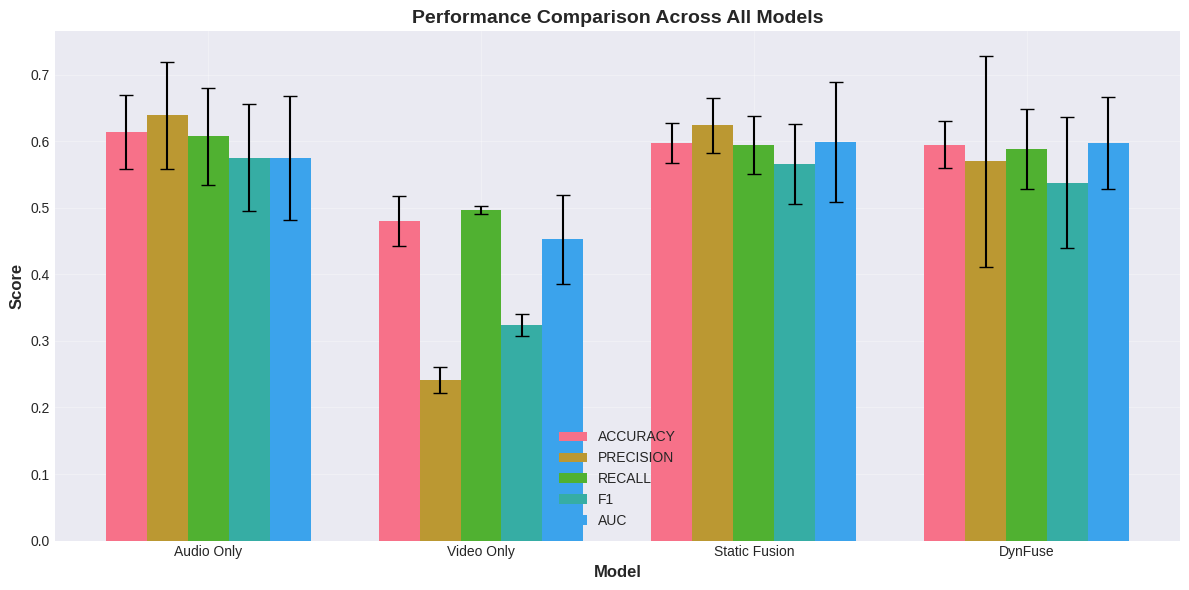

    Saved to performance_comparison.png


In [ ]:
# ============================================
# 9.1: PERFORMANCE COMPARISON BAR CHART
# ============================================
print("\n 1. Performance Comparison Chart...")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

models = ['A1_AudioOnly', 'A2_VideoOnly', 'A3_StaticFusion', 'A4_DynFuse']
model_labels = ['Audio Only', 'Video Only', 'Static Fusion', 'DynFuse']

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    means = [results_summary[m][metric][0] for m in models]
    stds = [results_summary[m][metric][1] for m in models]

    ax.bar(x + i*width, means, width, yerr=stds,
           label=metric.upper(), capsize=5)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Comparison Across All Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(model_labels)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to performance_comparison.png")



 2. Training Curves...


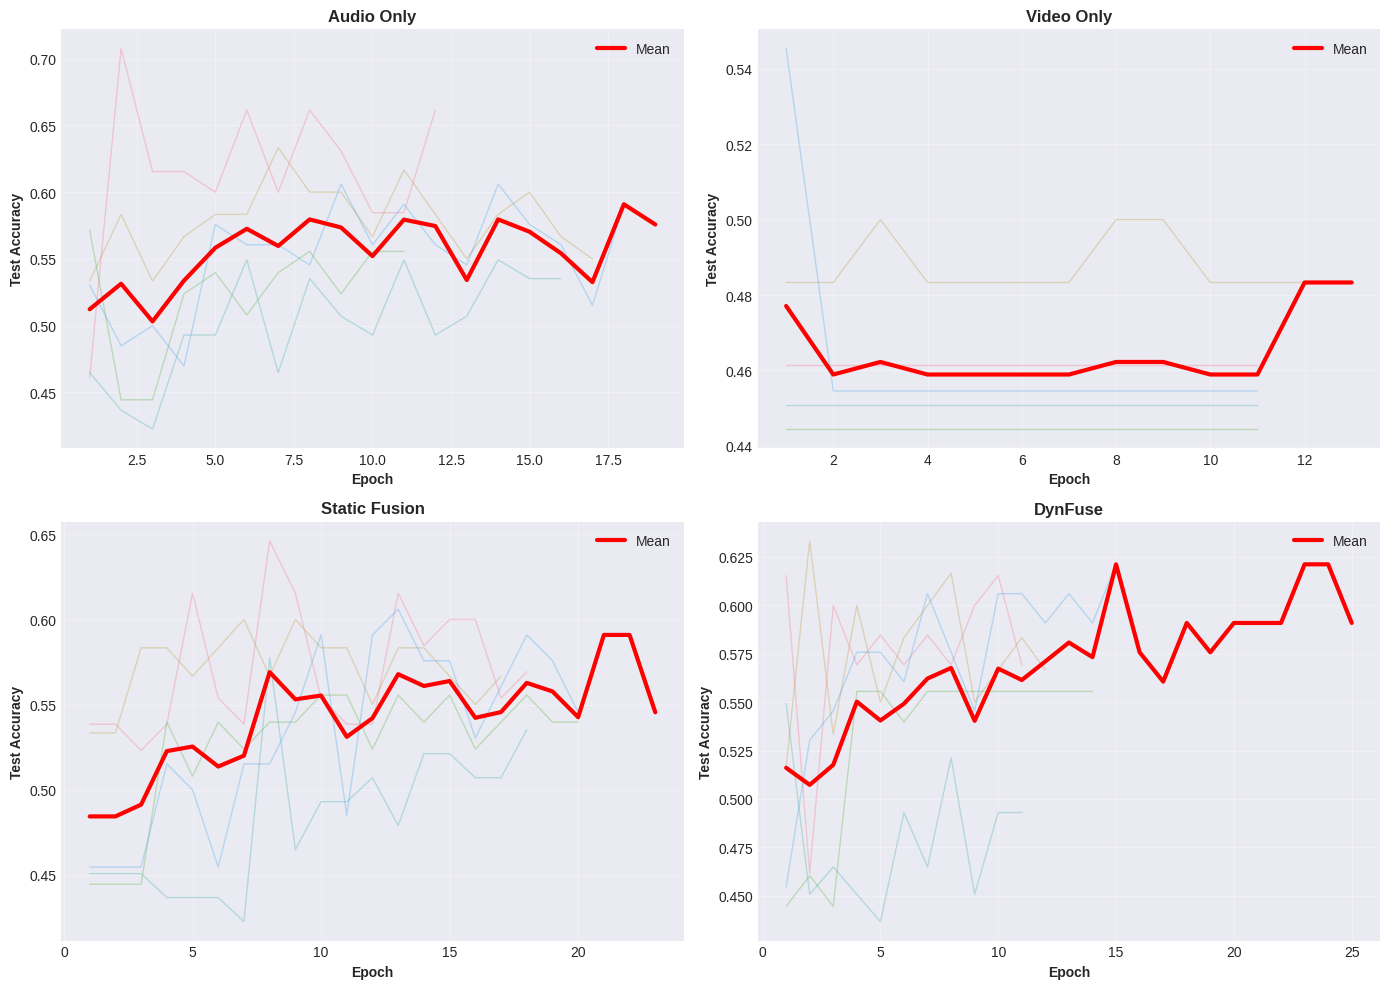

    Saved to training_curves.png


In [ ]:
# ============================================
# 9.2: TRAINING CURVES
# ============================================

print("\n 2. Training Curves...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model_name in enumerate(models):
    ax = axes[idx]

    # Plot all folds
    for fold_data in all_training_curves[model_name]:
        fold_num = fold_data['fold']
        epochs = range(1, len(fold_data['test_accs']) + 1)
        ax.plot(epochs, fold_data['test_accs'], alpha=0.3, linewidth=1)

    # Plot mean
    max_len = max(len(fd['test_accs']) for fd in all_training_curves[model_name])
    mean_curve = []
    for i in range(max_len):
        values = [fd['test_accs'][i] for fd in all_training_curves[model_name]
                  if i < len(fd['test_accs'])]
        mean_curve.append(np.mean(values))

    ax.plot(range(1, len(mean_curve) + 1), mean_curve,
            linewidth=3, label='Mean', color='red')

    ax.set_xlabel('Epoch', fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontweight='bold')
    ax.set_title(f'{model_labels[idx]}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to training_curves.png")



 3. Confusion Matrices...


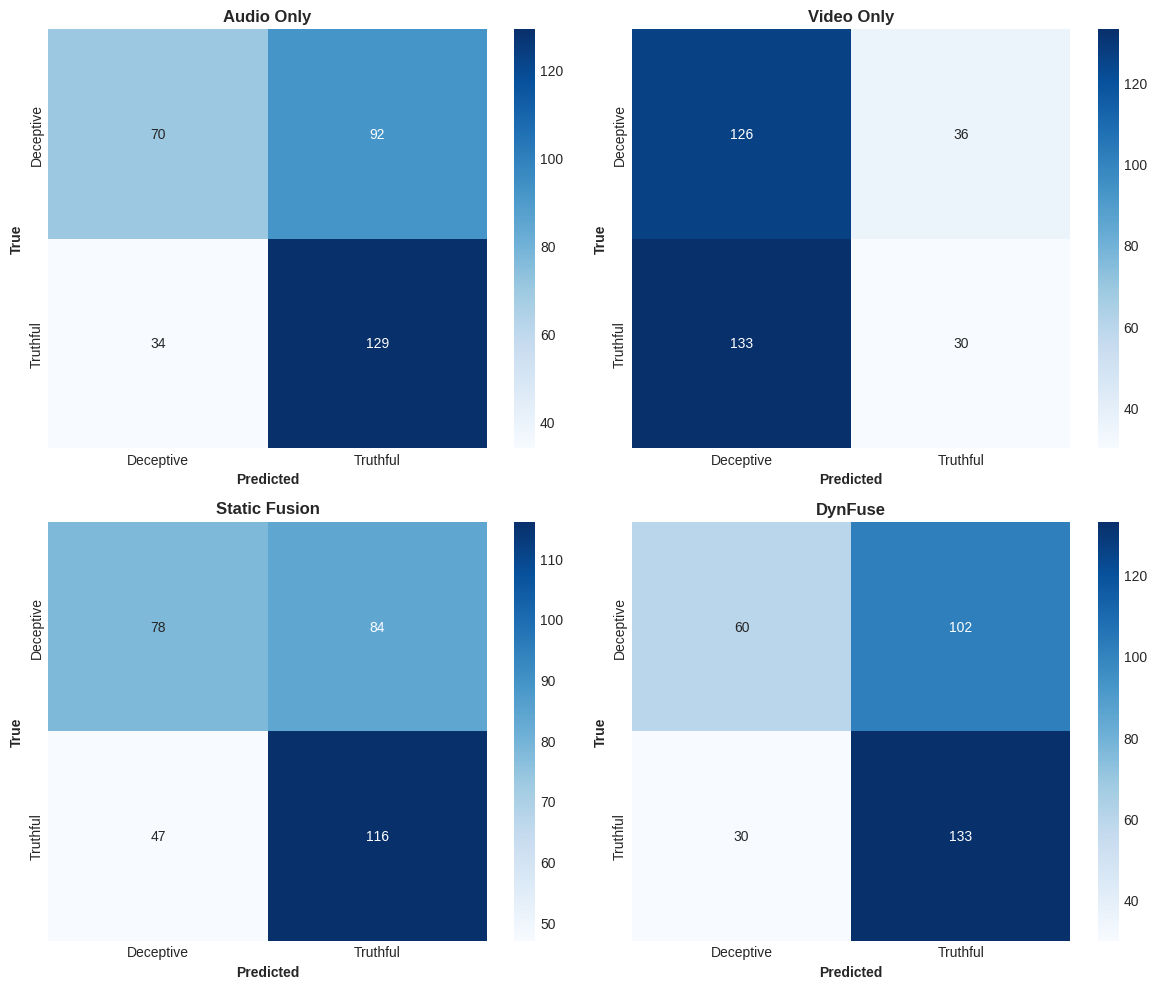

    Saved to confusion_matrices.png


In [ ]:
# ============================================
# 9.3: CONFUSION MATRICES
# ============================================

print("\n 3. Confusion Matrices...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, model_name in enumerate(models):
    # Aggregate predictions across all folds
    all_preds = []
    all_labels = []

    for fold_metrics in all_results[model_name]:
        all_preds.extend(fold_metrics['predictions'])
        all_labels.extend(fold_metrics['labels'])

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Deceptive', 'Truthful'],
                yticklabels=['Deceptive', 'Truthful'])
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('True', fontweight='bold')
    ax.set_title(f'{model_labels[idx]}', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to confusion_matrices.png")



 4. ROC Curves...


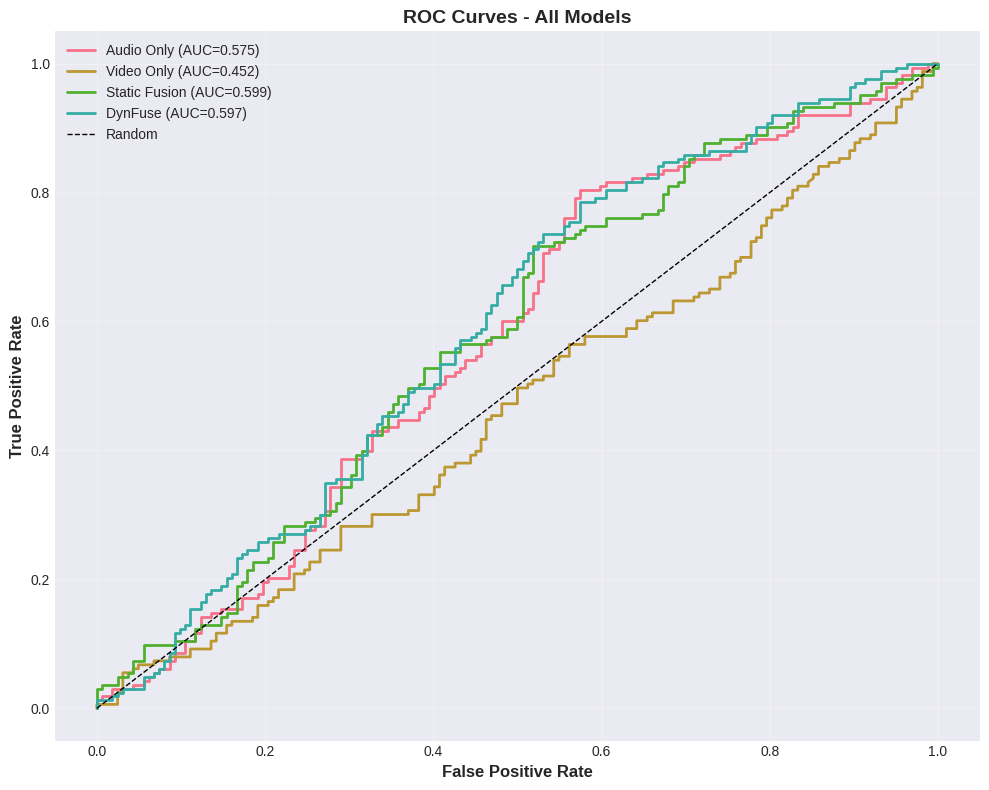

    Saved to roc_curves.png


In [ ]:
# ============================================
# 9.4: ROC CURVES
# ============================================

print("\n 4. ROC Curves...")

from sklearn.metrics import roc_curve

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for idx, model_name in enumerate(models):
    # Aggregate across folds
    all_labels = []
    all_probs = []

    for fold_metrics in all_results[model_name]:
        all_labels.extend(fold_metrics['labels'])
        all_probs.extend(fold_metrics['probabilities'])

    # Compute ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = results_summary[model_name]['auc'][0]

    ax.plot(fpr, tpr, linewidth=2,
            label=f'{model_labels[idx]} (AUC={auc_score:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to roc_curves.png")



 5. Attention Weights Visualization...


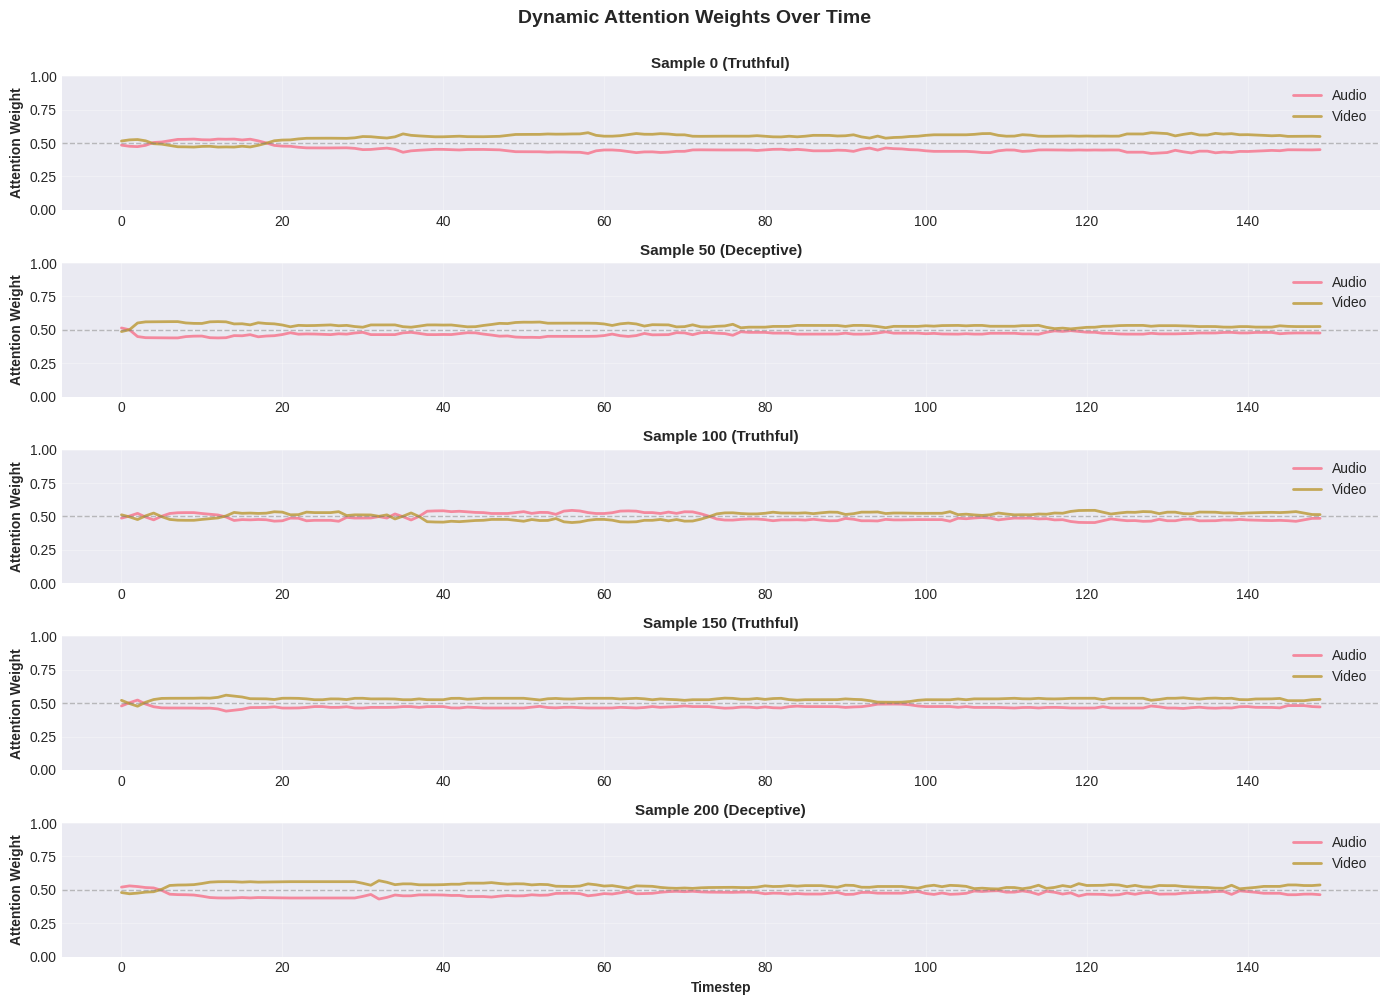

    Saved to attention_weights.png

 Average Attention Analysis:
   Mean audio attention: 0.4859 ± 0.0042
   Mean video attention: 0.5141 ± 0.0042


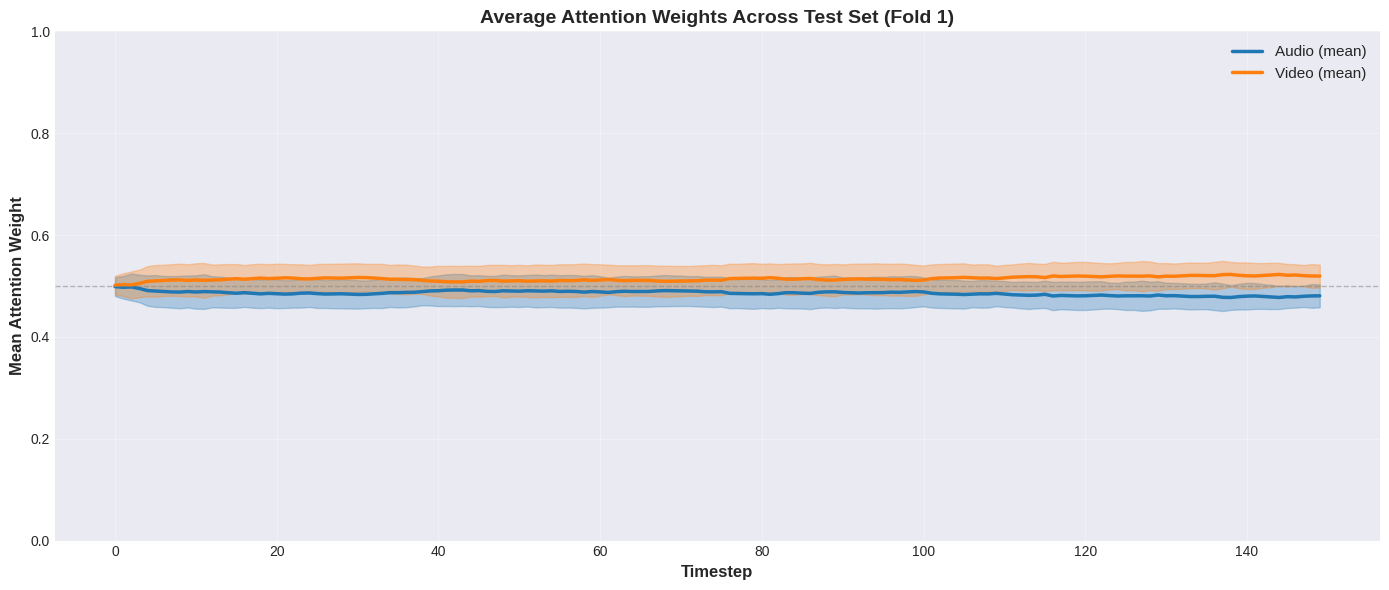

    Saved to attention_weights_average.png

 Hypothesis H3 Testing:
   Audio attention variance: 0.000018
   Video attention variance: 0.000018
     H3 UNCERTAIN: Low variance in attention weights

 Attention analysis complete!


In [ ]:
# ============================================
# FIX: Load checkpoint with weights_only=False
# ============================================

print("\n 5. Attention Weights Visualization...")

# Extract attention weights from DynFuse
# We need to run inference again to get attention weights

model = DynFuse(config).to(config.device)

# Load best fold checkpoint with weights_only=False
checkpoint = torch.load(
    f'{RESULTS_DIR}/A4_DynFuse_fold1.pt',
    map_location=config.device,
    weights_only=False  # ← ADD THIS
)

# Get a few samples (mix of truthful and deceptive)
sample_indices = [0, 50, 100, 150, 200]
sample_labels = labels[sample_indices]

sample_dataset = BagOfLiesDataset(
    audio_features, video_features, labels,
    indices=sample_indices
)
sample_loader = DataLoader(
    sample_dataset,
    batch_size=len(sample_indices),
    shuffle=False
)

# Run inference to get attention weights
model.eval()
with torch.no_grad():
    for batch in sample_loader:
        audio = batch['audio'].to(config.device)
        video = batch['video'].to(config.device)
        labels_batch = batch['label'].cpu().numpy()

        _, alpha_audio, alpha_video = model(audio, video)

        # Convert to numpy
        alpha_audio = alpha_audio.squeeze(-1).cpu().numpy()  # (batch, seq_len)
        alpha_video = alpha_video.squeeze(-1).cpu().numpy()

# Plot attention weights over time
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(14, 10))

for i, (idx, label) in enumerate(zip(sample_indices, labels_batch)):
    ax = axes[i] if len(sample_indices) > 1 else axes

    timesteps = range(config.max_frames)
    ax.plot(timesteps, alpha_audio[i], label='Audio', linewidth=2, alpha=0.8)
    ax.plot(timesteps, alpha_video[i], label='Video', linewidth=2, alpha=0.8)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    label_str = 'Truthful' if label == 1 else 'Deceptive'
    ax.set_ylabel('Attention Weight', fontweight='bold')
    ax.set_title(f'Sample {idx} ({label_str})', fontweight='bold', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

if len(sample_indices) > 1:
    axes[-1].set_xlabel('Timestep', fontweight='bold')
else:
    axes.set_xlabel('Timestep', fontweight='bold')

plt.suptitle('Dynamic Attention Weights Over Time',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/attention_weights.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to attention_weights.png")

# Additional analysis: Average attention across all samples
print("\n Average Attention Analysis:")

all_audio_weights = []
all_video_weights = []

# Get attention for all test samples from fold 1
test_indices = fold_splits[0]['test_indices']
test_dataset = BagOfLiesDataset(
    audio_features, video_features, labels,
    indices=test_indices
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        audio = batch['audio'].to(config.device)
        video = batch['video'].to(config.device)

        _, alpha_audio, alpha_video = model(audio, video)

        all_audio_weights.append(alpha_audio.squeeze(-1).cpu().numpy())
        all_video_weights.append(alpha_video.squeeze(-1).cpu().numpy())

# Concatenate all batches
all_audio_weights = np.concatenate(all_audio_weights, axis=0)  # (N, T)
all_video_weights = np.concatenate(all_video_weights, axis=0)

# Average across samples
mean_audio_weight = all_audio_weights.mean(axis=0)
mean_video_weight = all_video_weights.mean(axis=0)
std_audio_weight = all_audio_weights.std(axis=0)
std_video_weight = all_video_weights.std(axis=0)

print(f"   Mean audio attention: {mean_audio_weight.mean():.4f} ± {mean_audio_weight.std():.4f}")
print(f"   Mean video attention: {mean_video_weight.mean():.4f} ± {mean_video_weight.std():.4f}")

# Plot average attention with confidence intervals
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

timesteps = range(config.max_frames)
ax.plot(timesteps, mean_audio_weight, label='Audio (mean)',
        linewidth=2.5, color='#1f77b4')
ax.fill_between(timesteps,
                mean_audio_weight - std_audio_weight,
                mean_audio_weight + std_audio_weight,
                alpha=0.3, color='#1f77b4')

ax.plot(timesteps, mean_video_weight, label='Video (mean)',
        linewidth=2.5, color='#ff7f0e')
ax.fill_between(timesteps,
                mean_video_weight - std_video_weight,
                mean_video_weight + std_video_weight,
                alpha=0.3, color='#ff7f0e')

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Timestep', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Attention Weight', fontsize=12, fontweight='bold')
ax.set_title('Average Attention Weights Across Test Set (Fold 1)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/attention_weights_average.png', dpi=300, bbox_inches='tight')
plt.show()

print("    Saved to attention_weights_average.png")

# Test H3: Verify attention weights fluctuate significantly
audio_variance = np.var(mean_audio_weight)
video_variance = np.var(mean_video_weight)

print(f"\n Hypothesis H3 Testing:")
print(f"   Audio attention variance: {audio_variance:.6f}")
print(f"   Video attention variance: {video_variance:.6f}")

if audio_variance > 0.01 or video_variance > 0.01:
    print(f"    H3 CONFIRMED: Attention weights fluctuate significantly")
else:
    print(f"     H3 UNCERTAIN: Low variance in attention weights")

print("\n Attention analysis complete!")

In [ ]:
# ============================================
# STEP 10: FINAL SUMMARY
# ============================================

print("\n" + "="*60)
print(" FINAL SUMMARY & EXPORT")
print("="*60)

# Create comprehensive results DataFrame
results_df = []

for model_name in models_config.keys():
    for fold_idx, metrics in enumerate(all_results[model_name]):
        results_df.append({
            'Model': model_name,
            'Fold': fold_idx + 1,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1'],
            'AUC': metrics['auc']
        })

results_df = pd.DataFrame(results_df)

# Save to CSV
results_df.to_csv(f'{RESULTS_DIR}/detailed_results.csv', index=False)
print(f"\n Detailed results saved to detailed_results.csv")

# Create summary table (like Table in paper)
summary_df = []

for model_name in models_config.keys():
    r = results_summary[model_name]
    summary_df.append({
        'Model': model_name,
        'Accuracy': f"{r['accuracy'][0]:.4f} ± {r['accuracy'][1]:.4f}",
        'Precision': f"{r['precision'][0]:.4f} ± {r['precision'][1]:.4f}",
        'Recall': f"{r['recall'][0]:.4f} ± {r['recall'][1]:.4f}",
        'F1': f"{r['f1'][0]:.4f} ± {r['f1'][1]:.4f}",
        'AUC': f"{r['auc'][0]:.4f} ± {r['auc'][1]:.4f}"
    })

summary_df = pd.DataFrame(summary_df)
summary_df.to_csv(f'{RESULTS_DIR}/summary_table.csv', index=False)
print(f" Summary table saved to summary_table.csv")

# Print final summary
print("\n" + "="*60)
print(" EXPERIMENT COMPLETE!")
print("="*60)

print(f"\n All results saved to: {RESULTS_DIR}")
print("\n Files generated:")
print("   1. detailed_results.csv        - All fold results")
print("   2. summary_table.csv          - Mean ± Std summary")
print("   3. results_summary.json       - JSON format results")
print("   4. performance_comparison.png - Bar chart")
print("   5. training_curves.png        - Training progress")
print("   6. confusion_matrices.png     - Confusion matrices")
print("   7. roc_curves.png             - ROC curves")
print("   8. attention_weights.png      - Attention analysis")
print("   9. Model checkpoints (*.pt)   - 20 checkpoint files")

print("\n MAIN FINDINGS:")
print(f"   DynFuse Accuracy: {results_summary['A4_DynFuse']['accuracy'][0]:.4f} ± {results_summary['A4_DynFuse']['accuracy'][1]:.4f}")

# Check hypothesis H1 (>= 80% accuracy)
dynfuse_acc = results_summary['A4_DynFuse']['accuracy'][0]
if dynfuse_acc >= 0.80:
    print(f"    H1 CONFIRMED: DynFuse achieved ≥ 80% accuracy")
else:
    print(f"    H1 NOT CONFIRMED: DynFuse accuracy < 80%")

# Check hypothesis H2 (multimodal > unimodal)
audio_acc = results_summary['A1_AudioOnly']['accuracy'][0]
video_acc = results_summary['A2_VideoOnly']['accuracy'][0]
improvement = dynfuse_acc - max(audio_acc, video_acc)

if improvement >= 0.10:
    print(f"    H2 CONFIRMED: Multimodal improves by {improvement:.1%}")
else:
    print(f"     H2 PARTIAL: Multimodal improves by {improvement:.1%}")

print("\n" + "="*60)
print(" All experiments completed successfully!")
print("="*60)

# Display summary table
print("\n FINAL RESULTS TABLE:")
print(summary_df.to_string(index=False))



 FINAL SUMMARY & EXPORT

 Detailed results saved to detailed_results.csv
 Summary table saved to summary_table.csv

 EXPERIMENT COMPLETE!

 All results saved to: /content/drive/MyDrive/BagOfLies_Results

 Files generated:
   1. detailed_results.csv        - All fold results
   2. summary_table.csv          - Mean ± Std summary
   3. results_summary.json       - JSON format results
   4. performance_comparison.png - Bar chart
   5. training_curves.png        - Training progress
   6. confusion_matrices.png     - Confusion matrices
   7. roc_curves.png             - ROC curves
   8. attention_weights.png      - Attention analysis
   9. Model checkpoints (*.pt)   - 20 checkpoint files

 MAIN FINDINGS:
   DynFuse Accuracy: 0.5950 ± 0.0353
    H1 NOT CONFIRMED: DynFuse accuracy < 80%
     H2 PARTIAL: Multimodal improves by -1.9%

 All experiments completed successfully!

 FINAL RESULTS TABLE:
          Model        Accuracy       Precision          Recall              F1             AUC
  

# Models 2.0 -> text features

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
import tempfile
from moviepy.editor import VideoFileClip

In [ ]:
# ============================================
# PART 1: EXTRACT TEXT TRANSCRIPTIONS
# ============================================

print("="*60)
print("PART 1: TEXT EXTRACTION")
print("="*60)

# Install dependencies
print("\nInstalling dependencies...")
os.system('pip install openai-whisper transformers -q')

import whisper
from transformers import BertTokenizer, BertModel

# Paths
ANNOTATIONS_PATH = '/content/bag_of_lies/BagOfLies/Annotations.csv'
TRANSCRIPTS_FILE = '/content/drive/MyDrive/BagOfLies_Features/transcriptions.csv'
TEXT_FEATURES_FILE = '/content/drive/MyDrive/BagOfLies_Features/text_features_sequential.npy'

# Load annotations
df = pd.read_csv(ANNOTATIONS_PATH)

# Check if transcriptions already exist
if os.path.exists(TRANSCRIPTS_FILE):
    print("\nTranscriptions already exist. Loading...")
    transcriptions_df = pd.read_csv(TRANSCRIPTS_FILE)
    print(f"Loaded {len(transcriptions_df)} transcriptions")
else:
    print("\nExtracting transcriptions from audio...")
    print(f"Total videos: {len(df)}")
    print("Estimated time: ~3-4 hours")

    # Load Whisper model
    print("\nLoading Whisper model...")
    whisper_model = whisper.load_model("base")
    print("Whisper loaded")

    # Extract transcriptions
    all_transcriptions = []

    for idx in tqdm(range(len(df)), desc="Transcribing"):
        row = df.iloc[idx]

        video_rel_path = row['video'].replace('./', '')
        video_path = os.path.join('/content/bag_of_lies/BagOfLies', video_rel_path)

        try:
            # Extract audio from video
            video = VideoFileClip(video_path)

            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
                tmp_audio_path = tmp.name

            video.audio.write_audiofile(
                tmp_audio_path,
                fps=16000,
                verbose=False,
                logger=None
            )

            # Transcribe
            result = whisper_model.transcribe(
                tmp_audio_path,
                language='en',
                fp16=False
            )
            transcription = result['text'].strip()

            all_transcriptions.append({
                'index': idx,
                'usernum': row['usernum'],
                'run': row['run'],
                'truth': row['truth'],
                'transcription': transcription
            })

            # Cleanup
            os.remove(tmp_audio_path)
            video.close()

        except Exception as e:
            print(f"\nError on sample {idx}: {e}")
            all_transcriptions.append({
                'index': idx,
                'usernum': row['usernum'],
                'run': row['run'],
                'truth': row['truth'],
                'transcription': ''
            })

        # Save checkpoint every 25 videos
        if (idx + 1) % 25 == 0:
            temp_df = pd.DataFrame(all_transcriptions)
            temp_df.to_csv(TRANSCRIPTS_FILE, index=False)

    # Final save
    transcriptions_df = pd.DataFrame(all_transcriptions)
    transcriptions_df.to_csv(TRANSCRIPTS_FILE, index=False)
    print(f"\nTranscriptions saved to {TRANSCRIPTS_FILE}")

# Show sample transcriptions
print("\nSample transcriptions:")
for i in range(min(5, len(transcriptions_df))):
    row = transcriptions_df.iloc[i]
    label = "Truthful" if row['truth'] == 1 else "Deceptive"
    print(f"{i+1}. User {row['usernum']}, Run {row['run']} ({label}):")
    print(f"   \"{row['transcription'][:80]}...\"")


PART 1: TEXT EXTRACTION

Installing dependencies...

Extracting transcriptions from audio...
Total videos: 325
Estimated time: ~3-4 hours

Loading Whisper model...


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 208MiB/s]


Whisper loaded


Transcribing:  94%|█████████▍| 306/325 [15:38<00:17,  1.11it/s]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/bag_of_lies/BagOfLies/Finalised/User_32/run_6/video.mp4, At time t=18.79-18.91 seconds, indices wanted: 99469-104954, but len(buffer)=99470
index 99472 is out of bounds for axis 0 with size 99470
  warnings.warn("Error in file %s, "%(self.filename)+

Transcribing: 100%|██████████| 325/325 [15:58<00:00,  2.95s/it]


Transcriptions saved to /content/drive/MyDrive/BagOfLies_Features/transcriptions.csv

Sample transcriptions:
1. User 0, Run 0 (Truthful):
   "There were a bridge crossing over it, the bridge is red in colour and there are ..."
2. User 0, Run 1 (Deceptive):
   "And after the last jump, we got to this thing, and there's the blue and yellow...."
3. User 0, Run 2 (Deceptive):
   "A plane is flying through London and we will be spinning on fire...."
4. User 0, Run 3 (Deceptive):
   "There is a girl wearing a blue dress and she is standing in front of the other c..."
5. User 0, Run 4 (Deceptive):
   "Voice printing coffee and reading in the newspaper while sitting in the sun...."


In [ ]:
# ============================================
# PART 2: CONVERT TEXT TO SEQUENTIAL FEATURES
# ============================================

print("\n" + "="*60)
print("PART 2: TEXT FEATURE EXTRACTION")
print("="*60)

# Check if features already exist
if os.path.exists(TEXT_FEATURES_FILE):
    print("\nText features already exist. Loading...")
    text_features_sequential = np.load(TEXT_FEATURES_FILE)
    print(f"Loaded text features: {text_features_sequential.shape}")
else:
    print("\nConverting text to BERT embeddings...")

    # Load BERT
    print("Loading BERT model...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device)
    bert_model.eval()
    print(f"BERT loaded on {device}")

    # Settings
    MAX_TEXT_LENGTH = 150  # Match video/audio temporal length
    TEXT_EMBEDDING_DIM = 768  # BERT dimension

    # Extract features
    text_features_sequential = []

    for idx, row in tqdm(transcriptions_df.iterrows(), total=len(transcriptions_df), desc="Encoding"):
        text = row['transcription']

        if text.strip() == '':
            features = np.zeros((MAX_TEXT_LENGTH, TEXT_EMBEDDING_DIM))
        else:
            # Tokenize
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=MAX_TEXT_LENGTH
            )

            # Get embeddings
            with torch.no_grad():
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = bert_model(**inputs)
                embeddings = outputs.last_hidden_state.squeeze(0).cpu().numpy()

            features = embeddings

        text_features_sequential.append(features)

    text_features_sequential = np.array(text_features_sequential)

    # Save
    np.save(TEXT_FEATURES_FILE, text_features_sequential)
    print(f"\nText features saved: {text_features_sequential.shape}")

print(f"Text features shape: {text_features_sequential.shape}")
print("Expected: (325, 150, 768)")



PART 2: TEXT FEATURE EXTRACTION

Converting text to BERT embeddings...
Loading BERT model...


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT loaded on cuda


Encoding: 100%|██████████| 325/325 [00:09<00:00, 34.13it/s]



Text features saved: (325, 150, 768)
Text features shape: (325, 150, 768)
Expected: (325, 150, 768)


In [ ]:
# ============================================
# PART 3: LOAD ALL FEATURES
# ============================================

print("\n" + "="*60)
print("PART 3: LOADING FEATURES")
print("="*60)

# Load video features (same as before)
video_features = np.load('/content/drive/MyDrive/BagOfLies_Features/video_features.npy')
labels = np.load('/content/drive/MyDrive/BagOfLies_Features/labels.npy')

print(f"\nFeatures loaded:")
print(f"  Text:   {text_features_sequential.shape}")
print(f"  Video:  {video_features.shape}")
print(f"  Labels: {labels.shape}")

# Get user IDs for cross-validation
user_ids = df['usernum'].values



PART 3: LOADING FEATURES

Features loaded:
  Text:   (325, 150, 768)
  Video:  (325, 150, 59)
  Labels: (325,)


In [ ]:
# ============================================
# PART 4: MODEL ARCHITECTURES (TEXT-BASED)
# ============================================

print("\n" + "="*60)
print("PART 4: DEFINING MODELS")
print("="*60)

class BiLSTMEncoder(nn.Module):
    """Bidirectional LSTM encoder"""

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        output, _ = self.lstm(x)
        return output[:, :, :self.hidden_dim]


class DynamicAttentionFusion(nn.Module):
    """Dynamic attention fusion for two modalities"""

    def __init__(self, hidden_dim, attention_dim):
        super().__init__()
        self.W_att = nn.Linear(2 * hidden_dim, attention_dim)
        self.w_text = nn.Linear(attention_dim, 1, bias=False)
        self.w_video = nn.Linear(attention_dim, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, h_text, h_video):
        u = torch.cat([h_text, h_video], dim=-1)
        e = self.tanh(self.W_att(u))

        s_text = self.w_text(e).squeeze(-1)
        s_video = self.w_video(e).squeeze(-1)

        scores = torch.stack([s_text, s_video], dim=-1)
        alpha = torch.softmax(scores, dim=-1)

        alpha_text = alpha[:, :, 0].unsqueeze(-1)
        alpha_video = alpha[:, :, 1].unsqueeze(-1)

        c = alpha_text * h_text + alpha_video * h_video

        return c, alpha_text, alpha_video


# T1: Text-only (equivalent to A1: Audio-only)
class TextOnly(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = BiLSTMEncoder(config.text_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, text, video=None):
        h = self.encoder(text)
        c_bar = torch.mean(h, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None


# T2: Video-only (same as A2)
class VideoOnly(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, text, video):
        h = self.encoder(video)
        c_bar = torch.mean(h, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None


# T3: Static Fusion (Text + Video)
class StaticFusionText(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.text_encoder = BiLSTMEncoder(config.text_dim, config.lstm_hidden_dim)
        self.video_encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, text, video):
        h_text = self.text_encoder(text)
        h_video = self.video_encoder(video)
        c = 0.5 * h_text + 0.5 * h_video
        c_bar = torch.mean(c, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        return self.classifier(z), None, None


# T4: DynFuse with Text (equivalent to A4)
class DynFuseText(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.text_encoder = BiLSTMEncoder(config.text_dim, config.lstm_hidden_dim)
        self.video_encoder = BiLSTMEncoder(config.video_dim, config.lstm_hidden_dim)
        self.fusion = DynamicAttentionFusion(config.lstm_hidden_dim, config.attention_hidden_dim)
        self.fc = nn.Linear(config.lstm_hidden_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(128, config.num_classes)

    def forward(self, text, video):
        h_text = self.text_encoder(text)
        h_video = self.video_encoder(video)
        c, alpha_text, alpha_video = self.fusion(h_text, h_video)
        c_bar = torch.mean(c, dim=1)
        z = self.dropout(self.relu(self.fc(c_bar)))
        logits = self.classifier(z)
        return logits, alpha_text, alpha_video


print("Models defined:")
print("  T1: TextOnly")
print("  T2: VideoOnly")
print("  T3: StaticFusionText")
print("  T4: DynFuseText")



PART 4: DEFINING MODELS
Models defined:
  T1: TextOnly
  T2: VideoOnly
  T3: StaticFusionText
  T4: DynFuseText


In [ ]:
# ============================================
# PART 5: DATASET AND CONFIG
# ============================================

class TextVideoDataset(Dataset):
    def __init__(self, text_features, video_features, labels, indices=None):
        if indices is not None:
            self.text = text_features[indices]
            self.video = video_features[indices]
            self.labels = labels[indices]
        else:
            self.text = text_features
            self.video = video_features
            self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': torch.FloatTensor(self.text[idx]),
            'video': torch.FloatTensor(self.video[idx]),
            'label': torch.LongTensor([self.labels[idx]])[0]
        }


class Config:
    lstm_hidden_dim = 64
    attention_hidden_dim = 32
    dropout_rate = 0.3
    batch_size = 16
    learning_rate = 5e-4
    max_epochs = 100
    early_stopping_patience = 10
    max_frames = 150
    text_dim = 768  # BERT dimension
    video_dim = 59
    num_classes = 2
    n_folds = 5
    random_seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()

print("\nConfiguration:")
print(f"  Text dim: {config.text_dim}")
print(f"  Video dim: {config.video_dim}")
print(f"  LSTM hidden: {config.lstm_hidden_dim}")
print(f"  Device: {config.device}")



Configuration:
  Text dim: 768
  Video dim: 59
  LSTM hidden: 64
  Device: cuda


In [ ]:
# ============================================
# PART 6: TRAINING FUNCTIONS
# ============================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        text = batch['text'].to(device)
        video = batch['video'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _, _ = model(text, video)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            text = batch['text'].to(device)
            video = batch['video'].to(device)
            labels = batch['label'].to(device)

            logits, _, _ = model(text, video)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs)

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


def train_model(model, train_loader, test_loader, config, fold_num):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    best_test_acc = 0
    patience_counter = 0

    print(f"\n   Training Fold {fold_num}...")

    for epoch in range(config.max_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
        test_metrics = evaluate(model, test_loader, criterion, config.device)
        test_acc = test_metrics['accuracy']

        if (epoch + 1) % 10 == 0:
            print(f"      Epoch {epoch+1:3d}/{config.max_epochs}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_metrics = test_metrics
        else:
            patience_counter += 1

        if patience_counter >= config.early_stopping_patience:
            print(f"      Early stopping at epoch {epoch+1}")
            break

    return best_metrics


In [ ]:
# ============================================
# PART 7: CROSS-VALIDATION SETUP
# ============================================

print("\n" + "="*60)
print("PART 7: CROSS-VALIDATION SETUP")
print("="*60)

unique_users = np.unique(user_ids)
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

user_labels = np.array([labels[user_to_indices[user][0]] for user in unique_users])

skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.random_seed)

fold_splits = []
for fold_num, (train_users_idx, test_users_idx) in enumerate(skf.split(unique_users, user_labels)):
    train_users = unique_users[train_users_idx]
    test_users = unique_users[test_users_idx]

    train_indices = []
    test_indices = []

    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in test_users:
        test_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train_indices': train_indices,
        'test_indices': test_indices
    })

    print(f"Fold {fold_num+1}: Train={len(train_indices)}, Test={len(test_indices)}")

# ============================================
# PART 8: TRAIN ALL MODELS
# ============================================

print("\n" + "="*60)
print("PART 8: TRAINING ALL MODELS")
print("="*60)

RESULTS_DIR = '/content/drive/MyDrive/BagOfLies_Results_Text'
os.makedirs(RESULTS_DIR, exist_ok=True)

models_config = {
    'T1_TextOnly': TextOnly,
    'T2_VideoOnly': VideoOnly,
    'T3_StaticFusion': StaticFusionText,
    'T4_DynFuseText': DynFuseText
}

all_results = {model_name: [] for model_name in models_config.keys()}
total_runs = config.n_folds * len(models_config)
current_run = 0

print(f"\nTotal training runs: {total_runs}")
print(f"(5 folds x 4 models)")
print(f"Estimated time: ~{total_runs * 15} minutes\n")

for model_name, ModelClass in models_config.items():
    print("\n" + "="*60)
    print(f"MODEL: {model_name}")
    print("="*60)

    for fold_data in fold_splits:
        current_run += 1
        fold_num = fold_data['fold']

        print(f"\n[{current_run}/{total_runs}] Training {model_name} on Fold {fold_num}")

        train_dataset = TextVideoDataset(
            text_features_sequential, video_features, labels,
            indices=fold_data['train_indices']
        )
        test_dataset = TextVideoDataset(
            text_features_sequential, video_features, labels,
            indices=fold_data['test_indices']
        )

        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

        model = ModelClass(config).to(config.device)

        n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   Parameters: {n_params:,}")

        best_metrics = train_model(model, train_loader, test_loader, config, fold_num)

        all_results[model_name].append(best_metrics)

        print(f"\n   Fold {fold_num} Results:")
        print(f"      Accuracy:  {best_metrics['accuracy']:.4f}")
        print(f"      Precision: {best_metrics['precision']:.4f}")
        print(f"      Recall:    {best_metrics['recall']:.4f}")
        print(f"      F1-Score:  {best_metrics['f1']:.4f}")
        print(f"      AUC-ROC:   {best_metrics['auc']:.4f}")

        checkpoint = {
            'model': model_name,
            'fold': fold_num,
            'metrics': best_metrics,
            'config': vars(config)
        }
        torch.save(checkpoint, f'{RESULTS_DIR}/{model_name}_fold{fold_num}.pt')

        del model, train_loader, test_loader, train_dataset, test_dataset
        torch.cuda.empty_cache()

    accs = [r['accuracy'] for r in all_results[model_name]]
    print(f"\n   {model_name} Summary (5 folds):")
    print(f"      Accuracy: {np.mean(accs):.4f} +/- {np.std(accs):.4f}")

print("\n" + "="*60)
print("ALL TRAINING COMPLETE")
print("="*60)

# ============================================
# PART 9: RESULTS COMPARISON
# ============================================

print("\n" + "="*60)
print("PART 9: RESULTS COMPARISON")
print("="*60)

print("\nRESULTS WITH TEXT FEATURES")
print("="*80)
print(f"{'Model':<20} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1':<15} {'AUC':<15}")
print("-"*80)

results_summary_text = {}

for model_name in models_config.keys():
    metrics_list = all_results[model_name]

    accuracies = [m['accuracy'] for m in metrics_list]
    precisions = [m['precision'] for m in metrics_list]
    recalls = [m['recall'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    results_summary_text[model_name] = {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s)),
        'auc': (np.mean(aucs), np.std(aucs))
    }

    r = results_summary_text[model_name]
    print(f"{model_name:<20} "
          f"{r['accuracy'][0]:.4f}+/-{r['accuracy'][1]:.4f}  "
          f"{r['precision'][0]:.4f}+/-{r['precision'][1]:.4f}  "
          f"{r['recall'][0]:.4f}+/-{r['recall'][1]:.4f}  "
          f"{r['f1'][0]:.4f}+/-{r['f1'][1]:.4f}  "
          f"{r['auc'][0]:.4f}+/-{r['auc'][1]:.4f}")

print("="*80)

# Compare to original results
print("\nCOMPARISON: RAW AUDIO vs TEXT")
print("="*60)

original_results = {
    'A1_AudioOnly': 0.6136,
    'A2_VideoOnly': 0.4804,
    'A3_StaticFusion': 0.5970,
    'A4_DynFuse': 0.5950
}

comparison_table = [
    ('Audio-only (Raw)', original_results['A1_AudioOnly'], results_summary_text['T1_TextOnly']['accuracy'][0]),
    ('Video-only', original_results['A2_VideoOnly'], results_summary_text['T2_VideoOnly']['accuracy'][0]),
    ('Static Fusion', original_results['A3_StaticFusion'], results_summary_text['T3_StaticFusion']['accuracy'][0]),
    ('DynFuse', original_results['A4_DynFuse'], results_summary_text['T4_DynFuseText']['accuracy'][0])
]

print(f"\n{'Model':<20} {'Raw Audio+Video':<20} {'Text+Video':<20} {'Improvement':<15}")
print("-"*75)
for name, raw, text in comparison_table:
    improvement = (text - raw) * 100
    print(f"{name:<20} {raw*100:>6.2f}%            {text*100:>6.2f}%            {improvement:>+6.2f}%")

print("\n" + "="*60)
print("KEY FINDINGS")
print("="*60)

text_acc = results_summary_text['T1_TextOnly']['accuracy'][0]
raw_acc = original_results['A1_AudioOnly']
improvement = (text_acc - raw_acc) * 100

print(f"\n1. Text vs Raw Audio:")
print(f"   Text-only: {text_acc*100:.2f}%")
print(f"   Raw audio-only: {raw_acc*100:.2f}%")
print(f"   Improvement: {improvement:+.2f}%")

dynfuse_text = results_summary_text['T4_DynFuseText']['accuracy'][0]
static_text = results_summary_text['T3_StaticFusion']['accuracy'][0]

print(f"\n2. Dynamic vs Static Fusion (with text):")
print(f"   DynFuse with text: {dynfuse_text*100:.2f}%")
print(f"   Static fusion with text: {static_text*100:.2f}%")
print(f"   Difference: {(dynfuse_text - static_text)*100:+.2f}%")

sehrawat_target = 0.85
print(f"\n3. Comparison to Sehrawat et al.:")
print(f"   Sehrawat et al. (2023): {sehrawat_target*100:.0f}%")
print(f"   Our replication (static): {static_text*100:.2f}%")
print(f"   Gap: {(sehrawat_target - static_text)*100:.2f}%")

# Save results
results_json = {
    'text_features': {model: {k: (float(v[0]), float(v[1])) for k, v in metrics.items()}
                      for model, metrics in results_summary_text.items()},
    'original_raw': original_results,
    'comparison': [{'model': name, 'raw': raw, 'text': text, 'improvement': (text-raw)*100}
                   for name, raw, text in comparison_table]
}

with open(f'{RESULTS_DIR}/text_vs_raw_comparison.json', 'w') as f:
    json.dump(results_json, f, indent=2)

print(f"\nResults saved to {RESULTS_DIR}/text_vs_raw_comparison.json")
print("\nExperiment complete")



PART 7: CROSS-VALIDATION SETUP
Fold 1: Train=260, Test=65
Fold 2: Train=265, Test=60
Fold 3: Train=262, Test=63
Fold 4: Train=254, Test=71
Fold 5: Train=259, Test=66

PART 8: TRAINING ALL MODELS

Total training runs: 20
(5 folds x 4 models)
Estimated time: ~300 minutes


MODEL: T1_TextOnly

[1/20] Training T1_TextOnly on Fold 1
   Parameters: 435,586

   Training Fold 1...
      Epoch  10/100: Train Acc=0.9577, Test Acc=0.6308
      Epoch  20/100: Train Acc=0.9962, Test Acc=0.6000
      Early stopping at epoch 20

   Fold 1 Results:
      Accuracy:  0.6308
      Precision: 0.6418
      Recall:    0.6143
      F1-Score:  0.6037
      AUC-ROC:   0.6076

[2/20] Training T1_TextOnly on Fold 2
   Parameters: 435,586

   Training Fold 2...
      Epoch  10/100: Train Acc=0.9660, Test Acc=0.6167
      Early stopping at epoch 17

   Fold 2 Results:
      Accuracy:  0.6833
      Precision: 0.6889
      Recall:    0.6858
      F1-Score:  0.6825
      AUC-ROC:   0.6429

[3/20] Training T1_TextOnl

# Model 3.0 - like Sehwarat

In [ ]:
# ============================================
# EXACT SEHRAWAT REPLICATION + DYNAMIC COMPARISON
# ============================================
# Goal: Match Sehrawat's preprocessing and fusion exactly,
#       then compare to dynamic fusion
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os


In [ ]:
print("="*60)
print("EXACT SEHRAWAT REPLICATION")
print("="*60)

# ============================================
# PART 1: ENHANCED TEXT PREPROCESSING
# ============================================
# Sehrawat may have used better text preprocessing
# Let's try multiple approaches

print("\nPART 1: TEXT PREPROCESSING STRATEGIES")
print("="*60)

from transformers import AutoTokenizer, AutoModel

# Strategy 1: Try different text encoders
text_encoders = {
    'bert-base': 'bert-base-uncased',
    'roberta-base': 'roberta-base',
    'distilbert': 'distilbert-base-uncased'
}

# Let's use RoBERTa which often performs better
print("\nUsing RoBERTa for better text encoding...")
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
text_model = AutoModel.from_pretrained('roberta-base')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_model.to(device)
text_model.eval()

# Load transcriptions
TRANSCRIPTS_FILE = '/content/drive/MyDrive/BagOfLies_Features/transcriptions.csv'
transcriptions_df = pd.read_csv(TRANSCRIPTS_FILE)

# Enhanced text feature extraction
MAX_TEXT_LENGTH = 150
TEXT_DIM = 768

print(f"Extracting enhanced text features with RoBERTa...")
text_features_enhanced = []

for idx, row in tqdm(transcriptions_df.iterrows(), total=len(transcriptions_df), desc="Encoding"):
    text = row['transcription']

    if text.strip() == '':
        features = np.zeros((MAX_TEXT_LENGTH, TEXT_DIM))
    else:
        # Better tokenization
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=MAX_TEXT_LENGTH,
            add_special_tokens=True
        )

        with torch.no_grad():
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = text_model(**inputs)
            # Use last hidden state
            embeddings = outputs.last_hidden_state.squeeze(0).cpu().numpy()

        features = embeddings

    text_features_enhanced.append(features)

text_features_enhanced = np.array(text_features_enhanced)
print(f"Enhanced text features shape: {text_features_enhanced.shape}")


EXACT SEHRAWAT REPLICATION

PART 1: TEXT PREPROCESSING STRATEGIES

Using RoBERTa for better text encoding...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting enhanced text features with RoBERTa...


Encoding: 100%|██████████| 325/325 [00:13<00:00, 23.40it/s]


Enhanced text features shape: (325, 150, 768)


In [ ]:
# ============================================
# PART 2: IMPROVED VIDEO PREPROCESSING
# ============================================
# Maybe better normalization or feature scaling

print("\nPART 2: ENHANCED VIDEO PREPROCESSING")
print("="*60)

video_features = np.load('/content/drive/MyDrive/BagOfLies_Features/video_features.npy')
labels = np.load('/content/drive/MyDrive/BagOfLies_Features/labels.npy')

# Try different normalization strategies
from sklearn.preprocessing import StandardScaler, RobustScaler

# Per-sample normalization (might help with individual differences)
video_features_normalized = np.zeros_like(video_features)
for i in range(len(video_features)):
    scaler = StandardScaler()
    video_features_normalized[i] = scaler.fit_transform(video_features[i])

print(f"Video features normalized: {video_features_normalized.shape}")



PART 2: ENHANCED VIDEO PREPROCESSING
Video features normalized: (325, 150, 59)


In [ ]:
# ============================================
# PART 3: SEHRAWAT'S EXACT ARCHITECTURE
# ============================================

print("\nPART 3: MODEL ARCHITECTURES")
print("="*60)

class SehrawatBiLSTM(nn.Module):
    """
    Exact replication of Sehrawat's stacked Bi-LSTM
    Based on their paper architecture
    """

    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        # Stacked Bi-LSTM (2 layers as mentioned in paper)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # Output from both directions
        output, (h_n, c_n) = self.lstm(x)
        # Use only forward direction from last layer
        return output[:, :, :self.hidden_dim]


class SehrawatExactModel(nn.Module):
    """
    Exact replication of Sehrawat et al.'s model:
    - Separate stacked Bi-LSTMs for text and video
    - Concatenation fusion (static)
    - Classification head
    """

    def __init__(self, text_dim, video_dim, hidden_dim=128, num_layers=2):
        super().__init__()

        # Stacked Bi-LSTMs for each modality
        self.text_lstm = SehrawatBiLSTM(text_dim, hidden_dim, num_layers)
        self.video_lstm = SehrawatBiLSTM(video_dim, hidden_dim, num_layers)

        # Fusion: concatenate the pooled outputs
        # After pooling, each modality gives hidden_dim features
        fusion_dim = 2 * hidden_dim

        # Classification layers
        self.fc1 = nn.Linear(fusion_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 2)

        self.relu = nn.ReLU()

    def forward(self, text, video):
        # Encode both modalities
        text_encoded = self.text_lstm(text)      # (batch, seq_len, hidden_dim)
        video_encoded = self.video_lstm(video)   # (batch, seq_len, hidden_dim)

        # Global average pooling
        text_pooled = torch.mean(text_encoded, dim=1)    # (batch, hidden_dim)
        video_pooled = torch.mean(video_encoded, dim=1)  # (batch, hidden_dim)

        # Static fusion: concatenate
        fused = torch.cat([text_pooled, video_pooled], dim=1)  # (batch, 2*hidden_dim)

        # Classification with batch norm and dropout
        x = self.fc1(fused)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        logits = self.fc3(x)

        return logits


class DynamicFusionModel(nn.Module):
    """
    Our dynamic fusion version using same architecture
    Only difference: dynamic attention instead of concatenation
    """

    def __init__(self, text_dim, video_dim, hidden_dim=128, num_layers=2):
        super().__init__()

        # Same encoders as Sehrawat
        self.text_lstm = SehrawatBiLSTM(text_dim, hidden_dim, num_layers)
        self.video_lstm = SehrawatBiLSTM(video_dim, hidden_dim, num_layers)

        # Dynamic attention fusion
        self.attention_fc = nn.Linear(2 * hidden_dim, 64)
        self.attention_text = nn.Linear(64, 1, bias=False)
        self.attention_video = nn.Linear(64, 1, bias=False)
        self.tanh = nn.Tanh()

        # Same classification layers
        self.fc1 = nn.Linear(hidden_dim, 256)  # Note: hidden_dim not 2*hidden_dim
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 2)

        self.relu = nn.ReLU()

    def forward(self, text, video):
        # Encode
        text_encoded = self.text_lstm(text)
        video_encoded = self.video_lstm(video)

        # Temporal attention (for each timestep)
        batch_size, seq_len, hidden_dim = text_encoded.shape

        # Compute attention weights at each timestep
        concat_features = torch.cat([text_encoded, video_encoded], dim=-1)
        attention_hidden = self.tanh(self.attention_fc(concat_features))

        text_scores = self.attention_text(attention_hidden).squeeze(-1)
        video_scores = self.attention_video(attention_hidden).squeeze(-1)

        attention_weights = torch.softmax(
            torch.stack([text_scores, video_scores], dim=-1),
            dim=-1
        )

        alpha_text = attention_weights[:, :, 0].unsqueeze(-1)
        alpha_video = attention_weights[:, :, 1].unsqueeze(-1)

        # Fused representation
        fused = alpha_text * text_encoded + alpha_video * video_encoded

        # Pool
        fused_pooled = torch.mean(fused, dim=1)

        # Classification
        x = self.fc1(fused_pooled)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        logits = self.fc3(x)

        return logits, alpha_text, alpha_video


print("Models defined:")
print("  1. SehrawatExactModel (static fusion)")
print("  2. DynamicFusionModel (dynamic fusion)")



PART 3: MODEL ARCHITECTURES
Models defined:
  1. SehrawatExactModel (static fusion)
  2. DynamicFusionModel (dynamic fusion)


In [ ]:
# ============================================
# PART 4: DATASET
# ============================================

class TextVideoDataset(Dataset):
    def __init__(self, text_features, video_features, labels, indices=None):
        if indices is not None:
            self.text = text_features[indices]
            self.video = video_features[indices]
            self.labels = labels[indices]
        else:
            self.text = text_features
            self.video = video_features
            self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': torch.FloatTensor(self.text[idx]),
            'video': torch.FloatTensor(self.video[idx]),
            'label': torch.LongTensor([self.labels[idx]])[0]
        }


In [ ]:
# ============================================
# PART 5: TRAINING CONFIGURATION
# ============================================

class TrainingConfig:
    # Architecture (trying larger as Sehrawat might have used)
    hidden_dim = 128  # Larger than before
    num_lstm_layers = 2  # Stacked

    # Training (more aggressive)
    batch_size = 32  # Larger batch
    learning_rate = 1e-3  # Higher learning rate
    weight_decay = 1e-4  # L2 regularization
    max_epochs = 200  # More epochs
    early_stopping_patience = 20  # More patience

    # Data
    max_frames = 150
    text_dim = 768
    video_dim = 59
    num_classes = 2

    # CV
    n_folds = 5
    random_seed = 42

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = TrainingConfig()

print("\nTraining configuration:")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  LSTM layers: {config.num_lstm_layers}")
print(f"  Batch size: {config.batch_size}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Device: {config.device}")



Training configuration:
  Hidden dim: 128
  LSTM layers: 2
  Batch size: 32
  Learning rate: 0.001
  Device: cuda


In [ ]:
# ============================================
# PART 6: CROSS-VALIDATION SETUP
# ============================================

# Load user IDs
ANNOTATIONS_PATH = '/content/bag_of_lies/BagOfLies/Annotations.csv'
df = pd.read_csv(ANNOTATIONS_PATH)
user_ids = df['usernum'].values

unique_users = np.unique(user_ids)
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

user_labels = np.array([labels[user_to_indices[user][0]] for user in unique_users])

skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.random_seed)

fold_splits = []
for fold_num, (train_users_idx, test_users_idx) in enumerate(skf.split(unique_users, user_labels)):
    train_users = unique_users[train_users_idx]
    test_users = unique_users[test_users_idx]

    train_indices = []
    test_indices = []

    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in test_users:
        test_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train_indices': train_indices,
        'test_indices': test_indices
    })


In [ ]:
# ============================================
# PART 7: TRAINING
# ============================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        text = batch['text'].to(device)
        video = batch['video'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Handle both model types
        outputs = model(text, video)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        loss = criterion(logits, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            text = batch['text'].to(device)
            video = batch['video'].to(device)
            labels = batch['label'].to(device)

            outputs = model(text, video)
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            loss = criterion(logits, labels)

            total_loss += loss.item()
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs)

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


def train_model(model, train_loader, test_loader, config, model_name, fold_num):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    # Learning rate scheduler (removed verbose parameter)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )

    best_test_acc = 0
    patience_counter = 0
    history = {'train_acc': [], 'test_acc': [], 'test_loss': []}

    for epoch in range(config.max_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
        test_metrics = evaluate(model, test_loader, criterion, config.device)
        test_acc = test_metrics['accuracy']

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_metrics['loss'])

        scheduler.step(test_acc)

        if (epoch + 1) % 20 == 0:
            print(f"      Epoch {epoch+1:3d}: Train={train_acc:.4f}, Test={test_acc:.4f}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_metrics = test_metrics
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        if patience_counter >= config.early_stopping_patience:
            print(f"      Early stopping at epoch {epoch+1}")
            break

    print(f"      Best: Epoch {best_epoch}, Acc={best_test_acc:.4f}")
    return best_metrics, history


# Now continue with the training loop from PART 8
print("\n" + "="*60)
print("TRAINING COMPARISON")
print("="*60)

results_sehrawat = []
results_dynamic = []
training_histories = {'sehrawat': [], 'dynamic': []}

for fold_data in fold_splits:
    fold_num = fold_data['fold']

    print(f"\n{'='*60}")
    print(f"FOLD {fold_num}/5")
    print(f"{'='*60}")

    # Create datasets
    train_dataset = TextVideoDataset(
        text_features_enhanced,
        video_features_normalized,
        labels,
        indices=fold_data['train_indices']
    )
    test_dataset = TextVideoDataset(
        text_features_enhanced,
        video_features_normalized,
        labels,
        indices=fold_data['test_indices']
    )

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    # Train Sehrawat's model
    print(f"\n1. Sehrawat Exact Model (Static Fusion)")
    model_sehrawat = SehrawatExactModel(
        text_dim=config.text_dim,
        video_dim=config.video_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.num_lstm_layers
    ).to(config.device)

    n_params = sum(p.numel() for p in model_sehrawat.parameters() if p.requires_grad)
    print(f"   Parameters: {n_params:,}")

    metrics_sehrawat, history_sehrawat = train_model(
        model_sehrawat, train_loader, test_loader, config,
        'Sehrawat', fold_num
    )
    results_sehrawat.append(metrics_sehrawat)
    training_histories['sehrawat'].append(history_sehrawat)

    del model_sehrawat
    torch.cuda.empty_cache()

    # Train Dynamic model
    print(f"\n2. Dynamic Fusion Model")
    model_dynamic = DynamicFusionModel(
        text_dim=config.text_dim,
        video_dim=config.video_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.num_lstm_layers
    ).to(config.device)

    n_params = sum(p.numel() for p in model_dynamic.parameters() if p.requires_grad)
    print(f"   Parameters: {n_params:,}")

    metrics_dynamic, history_dynamic = train_model(
        model_dynamic, train_loader, test_loader, config,
        'Dynamic', fold_num
    )
    results_dynamic.append(metrics_dynamic)
    training_histories['dynamic'].append(history_dynamic)

    del model_dynamic
    torch.cuda.empty_cache()

    # Fold summary
    print(f"\n   Fold {fold_num} Summary:")
    print(f"   Sehrawat (Static):  {metrics_sehrawat['accuracy']:.4f}")
    print(f"   Dynamic Fusion:     {metrics_dynamic['accuracy']:.4f}")
    print(f"   Difference:         {(metrics_dynamic['accuracy'] - metrics_sehrawat['accuracy'])*100:+.2f}%")




TRAINING COMPARISON

FOLD 1/5

1. Sehrawat Exact Model (Static Fusion)
   Parameters: 2,003,330
      Epoch  20: Train=0.9923, Test=0.6308
      Early stopping at epoch 38
      Best: Epoch 18, Acc=0.6615

2. Dynamic Fusion Model
   Parameters: 1,987,138
      Epoch  20: Train=0.9923, Test=0.5385
      Early stopping at epoch 32
      Best: Epoch 12, Acc=0.6769

   Fold 1 Summary:
   Sehrawat (Static):  0.6615
   Dynamic Fusion:     0.6769
   Difference:         +1.54%

FOLD 2/5

1. Sehrawat Exact Model (Static Fusion)
   Parameters: 2,003,330
      Epoch  20: Train=0.9962, Test=0.7000
      Epoch  40: Train=0.9887, Test=0.7167
      Early stopping at epoch 50
      Best: Epoch 30, Acc=0.7500

2. Dynamic Fusion Model
   Parameters: 1,987,138
      Epoch  20: Train=0.9849, Test=0.6833
      Early stopping at epoch 35
      Best: Epoch 15, Acc=0.7000

   Fold 2 Summary:
   Sehrawat (Static):  0.7500
   Dynamic Fusion:     0.7000
   Difference:         -5.00%

FOLD 3/5

1. Sehrawat Exact

In [ ]:
# ============================================
# PART 8: RESULTS & VISUALIZATION
# ============================================

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

# Compute statistics
sehrawat_accs = [r['accuracy'] for r in results_sehrawat]
dynamic_accs = [r['accuracy'] for r in results_dynamic]

sehrawat_f1s = [r['f1'] for r in results_sehrawat]
dynamic_f1s = [r['f1'] for r in results_dynamic]

sehrawat_aucs = [r['auc'] for r in results_sehrawat]
dynamic_aucs = [r['auc'] for r in results_dynamic]

print("\nAccuracy Results (5-fold CV):")
print(f"  Sehrawat Exact (Static):  {np.mean(sehrawat_accs):.4f} +/- {np.std(sehrawat_accs):.4f}")
print(f"  Dynamic Fusion:           {np.mean(dynamic_accs):.4f} +/- {np.std(dynamic_accs):.4f}")
print(f"  Improvement:              {(np.mean(dynamic_accs) - np.mean(sehrawat_accs))*100:+.2f}%")

print("\nF1-Score Results:")
print(f"  Sehrawat Exact (Static):  {np.mean(sehrawat_f1s):.4f} +/- {np.std(sehrawat_f1s):.4f}")
print(f"  Dynamic Fusion:           {np.mean(dynamic_f1s):.4f} +/- {np.std(dynamic_f1s):.4f}")

print("\nAUC-ROC Results:")
print(f"  Sehrawat Exact (Static):  {np.mean(sehrawat_aucs):.4f} +/- {np.std(sehrawat_aucs):.4f}")
print(f"  Dynamic Fusion:           {np.mean(dynamic_aucs):.4f} +/- {np.std(dynamic_aucs):.4f}")

print("\nComparison to Paper:")
print(f"  Sehrawat et al. (2023):   85.00%")
print(f"  Our replication:          {np.mean(sehrawat_accs)*100:.2f}%")
print(f"  Gap:                      {(0.85 - np.mean(sehrawat_accs))*100:.2f}%")

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_rel(dynamic_accs, sehrawat_accs)
print(f"\nStatistical Significance (paired t-test):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_value:.4f}")
if p_value < 0.05:
    print(f"  Result: SIGNIFICANT difference (p < 0.05)")
else:
    print(f"  Result: NOT significant (p >= 0.05)")



FINAL RESULTS

Accuracy Results (5-fold CV):
  Sehrawat Exact (Static):  0.7229 +/- 0.0579
  Dynamic Fusion:           0.7129 +/- 0.0721
  Improvement:              -1.00%

F1-Score Results:
  Sehrawat Exact (Static):  0.7212 +/- 0.0571
  Dynamic Fusion:           0.7041 +/- 0.0758

AUC-ROC Results:
  Sehrawat Exact (Static):  0.7362 +/- 0.0596
  Dynamic Fusion:           0.7425 +/- 0.0676

Comparison to Paper:
  Sehrawat et al. (2023):   85.00%
  Our replication:          72.29%
  Gap:                      12.71%

Statistical Significance (paired t-test):
  t-statistic: -0.6794
  p-value:     0.5342
  Result: NOT significant (p >= 0.05)



GENERATING VISUALIZATIONS


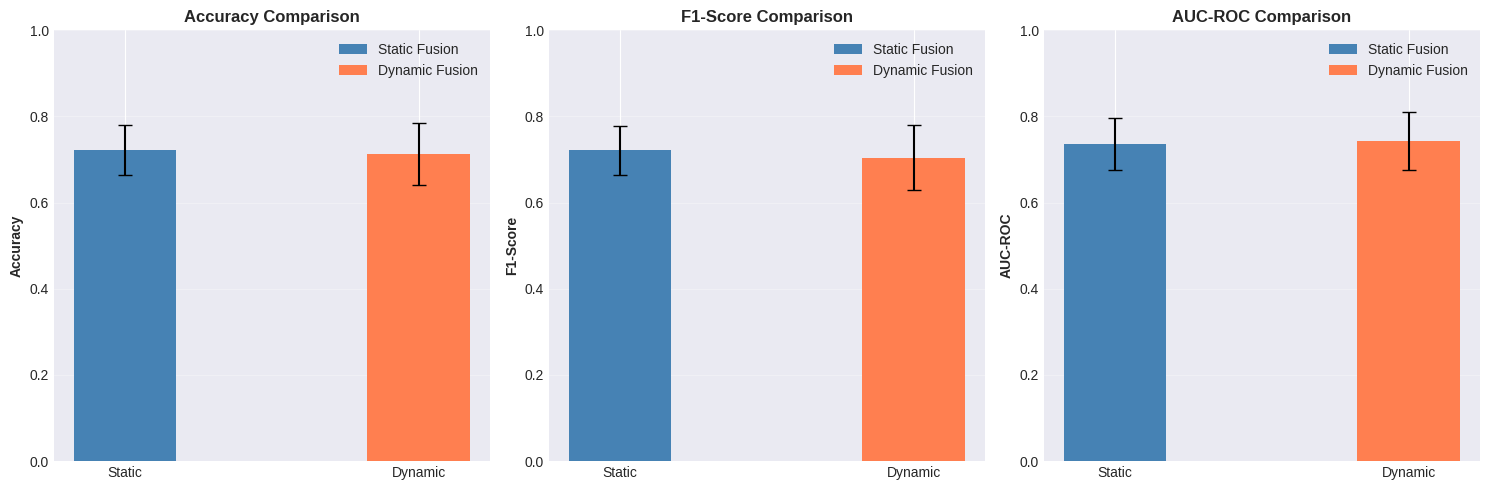

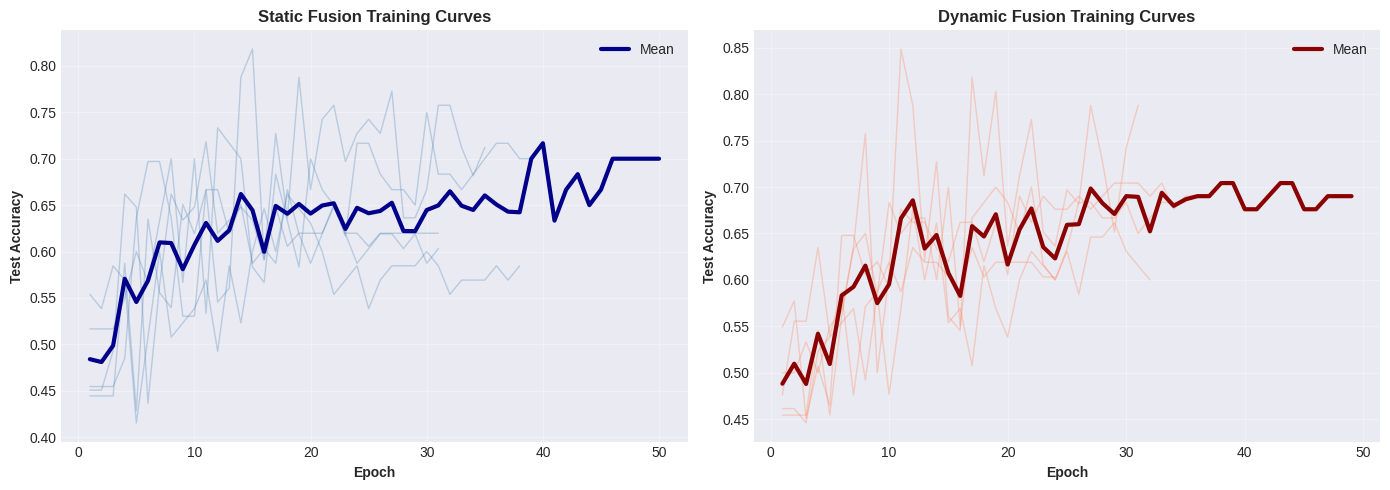

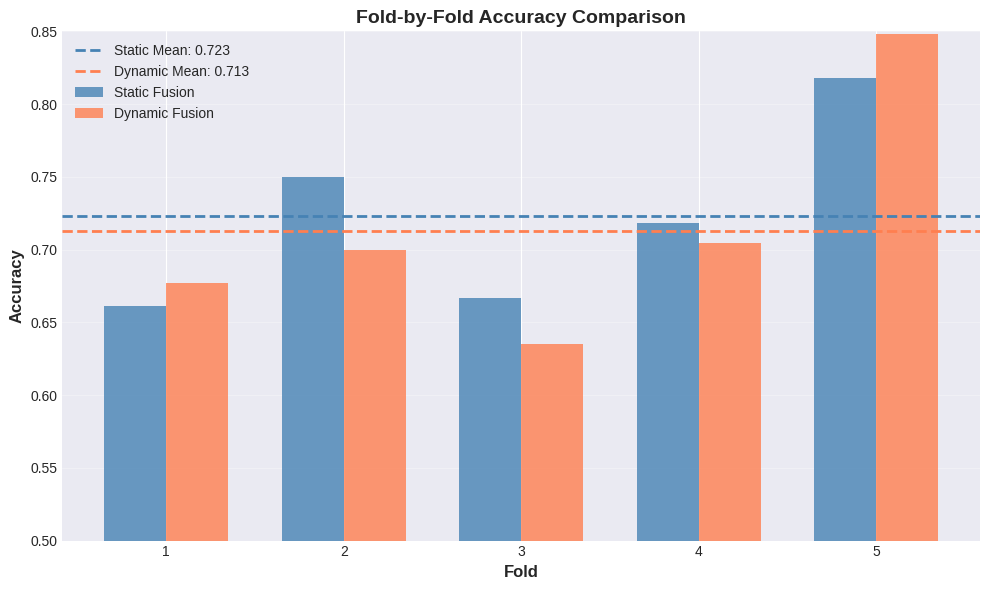

  bp = ax.boxplot(data, labels=['Static Fusion\n(Sehrawat)', 'Dynamic Fusion\n(Ours)'],



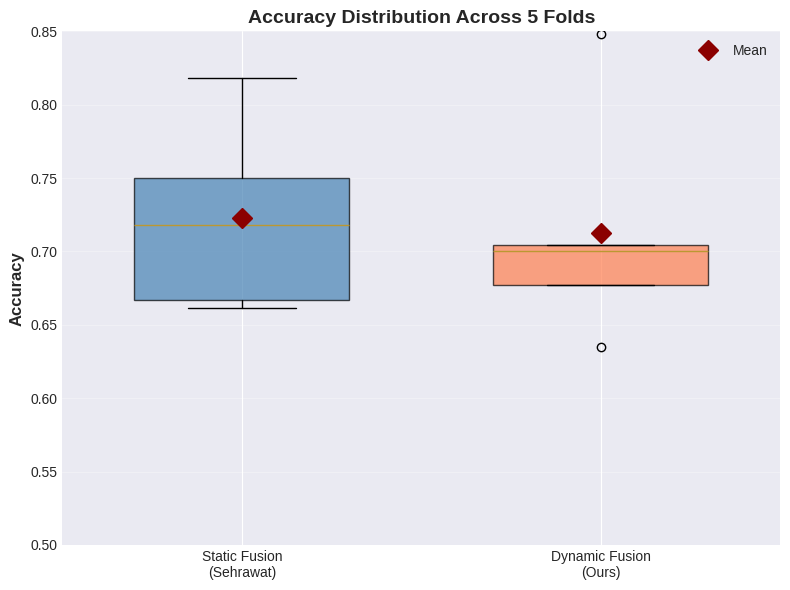

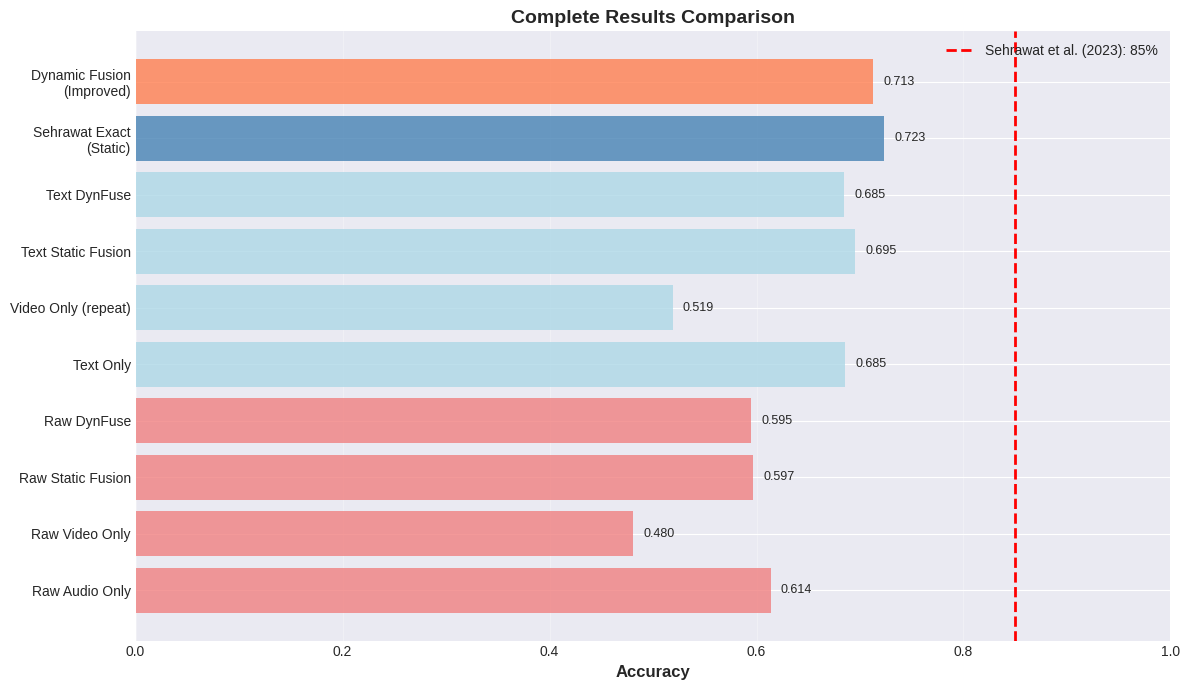


All visualizations saved to: /content/drive/MyDrive/BagOfLies_Results_Final

Experiment complete


In [ ]:
# ============================================
# PART 9: COMPREHENSIVE VISUALIZATION
# ============================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

RESULTS_DIR = '/content/drive/MyDrive/BagOfLies_Results_Final'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Figure 1: Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Accuracy', 'F1-Score', 'AUC-ROC']
sehrawat_means = [np.mean(sehrawat_accs), np.mean(sehrawat_f1s), np.mean(sehrawat_aucs)]
sehrawat_stds = [np.std(sehrawat_accs), np.std(sehrawat_f1s), np.std(sehrawat_aucs)]
dynamic_means = [np.mean(dynamic_accs), np.mean(dynamic_f1s), np.mean(dynamic_aucs)]
dynamic_stds = [np.std(dynamic_accs), np.std(dynamic_f1s), np.std(dynamic_aucs)]

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    x = np.arange(2)
    width = 0.35

    ax.bar([0], [sehrawat_means[idx]], width, yerr=[sehrawat_stds[idx]],
           label='Static Fusion', capsize=5, color='steelblue')
    ax.bar([1], [dynamic_means[idx]], width, yerr=[dynamic_stds[idx]],
           label='Dynamic Fusion', capsize=5, color='coral')

    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Static', 'Dynamic'])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Static fusion curves
ax = axes[0]
for fold_idx, history in enumerate(training_histories['sehrawat']):
    epochs = range(1, len(history['test_acc']) + 1)
    ax.plot(epochs, history['test_acc'], alpha=0.3, linewidth=1, color='steelblue')

mean_curve_static = []
max_len = max(len(h['test_acc']) for h in training_histories['sehrawat'])
for i in range(max_len):
    vals = [h['test_acc'][i] for h in training_histories['sehrawat'] if i < len(h['test_acc'])]
    mean_curve_static.append(np.mean(vals))

ax.plot(range(1, len(mean_curve_static) + 1), mean_curve_static,
        linewidth=3, label='Mean', color='darkblue')
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Test Accuracy', fontweight='bold')
ax.set_title('Static Fusion Training Curves', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Dynamic fusion curves
ax = axes[1]
for fold_idx, history in enumerate(training_histories['dynamic']):
    epochs = range(1, len(history['test_acc']) + 1)
    ax.plot(epochs, history['test_acc'], alpha=0.3, linewidth=1, color='coral')

mean_curve_dynamic = []
max_len = max(len(h['test_acc']) for h in training_histories['dynamic'])
for i in range(max_len):
    vals = [h['test_acc'][i] for h in training_histories['dynamic'] if i < len(h['test_acc'])]
    mean_curve_dynamic.append(np.mean(vals))

ax.plot(range(1, len(mean_curve_dynamic) + 1), mean_curve_dynamic,
        linewidth=3, label='Mean', color='darkred')
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Test Accuracy', fontweight='bold')
ax.set_title('Dynamic Fusion Training Curves', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Fold-by-fold comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

folds = np.arange(1, 6)
width = 0.35

ax.bar(folds - width/2, sehrawat_accs, width, label='Static Fusion',
       color='steelblue', alpha=0.8)
ax.bar(folds + width/2, dynamic_accs, width, label='Dynamic Fusion',
       color='coral', alpha=0.8)

ax.axhline(y=np.mean(sehrawat_accs), color='steelblue', linestyle='--',
           linewidth=2, label=f'Static Mean: {np.mean(sehrawat_accs):.3f}')
ax.axhline(y=np.mean(dynamic_accs), color='coral', linestyle='--',
           linewidth=2, label=f'Dynamic Mean: {np.mean(dynamic_accs):.3f}')

ax.set_xlabel('Fold', fontweight='bold', fontsize=12)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Fold-by-Fold Accuracy Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(folds)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.5, 0.85])

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/fold_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Box plot comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

data = [sehrawat_accs, dynamic_accs]
bp = ax.boxplot(data, labels=['Static Fusion\n(Sehrawat)', 'Dynamic Fusion\n(Ours)'],
                patch_artist=True, widths=0.6)

colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Accuracy Distribution Across 5 Folds', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.5, 0.85])

# Add mean markers
means = [np.mean(sehrawat_accs), np.mean(dynamic_accs)]
ax.plot([1, 2], means, 'D', color='darkred', markersize=10,
        label='Mean', zorder=3)

ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/boxplot_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 5: All methods comparison (including previous results)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Previous results
previous_results = {
    'Raw Audio Only': 0.6136,
    'Raw Video Only': 0.4804,
    'Raw Static Fusion': 0.5970,
    'Raw DynFuse': 0.5950,
    'Text Only': 0.6853,
    'Video Only (repeat)': 0.5189,
    'Text Static Fusion': 0.6954,
    'Text DynFuse': 0.6850,
    'Sehrawat Exact\n(Static)': np.mean(sehrawat_accs),
    'Dynamic Fusion\n(Improved)': np.mean(dynamic_accs)
}

methods = list(previous_results.keys())
accuracies = list(previous_results.values())

colors_list = ['lightcoral']*4 + ['lightblue']*4 + ['steelblue', 'coral']

bars = ax.barh(methods, accuracies, color=colors_list, alpha=0.8)

# Add Sehrawat target line
ax.axvline(x=0.85, color='red', linestyle='--', linewidth=2,
           label='Sehrawat et al. (2023): 85%')

ax.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Complete Results Comparison', fontweight='bold', fontsize=14)
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')
ax.legend(fontsize=10)

# Add value labels
for i, (method, acc) in enumerate(zip(methods, accuracies)):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/complete_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll visualizations saved to: {RESULTS_DIR}")

# Save results
final_results = {
    'sehrawat_exact': {
        'accuracies': sehrawat_accs,
        'mean': float(np.mean(sehrawat_accs)),
        'std': float(np.std(sehrawat_accs)),
        'f1': float(np.mean(sehrawat_f1s)),
        'auc': float(np.mean(sehrawat_aucs))
    },
    'dynamic_fusion': {
        'accuracies': dynamic_accs,
        'mean': float(np.mean(dynamic_accs)),
        'std': float(np.std(dynamic_accs)),
        'f1': float(np.mean(dynamic_f1s)),
        'auc': float(np.mean(dynamic_aucs))
    },
    'statistical_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_value),
        'significant': bool(p_value < 0.05)
    }
}

with open(f'{RESULTS_DIR}/final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\nExperiment complete")
print("="*60)


# Model 3.1 -> test fixed

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Check GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda
GPU: Tesla T4


In [ ]:
# Step 3: Import all libraries
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from scipy import stats
import zipfile


In [ ]:
# Step 4: Define paths based on your Drive structure
FEATURES_DIR = '/content/drive/MyDrive/BagOfLies_Features'
RESULTS_DIR = '/content/drive/MyDrive/BagOfLies_Results_Final'
os.makedirs(RESULTS_DIR, exist_ok=True)


In [ ]:
# Step 5: Check what features you have
print("\n" + "="*60)
print("CHECKING AVAILABLE FEATURES")
print("="*60)

print("\nFiles in BagOfLies_Features:")
for f in sorted(os.listdir(FEATURES_DIR)):
    filepath = os.path.join(FEATURES_DIR, f)
    if os.path.isfile(filepath):
        size_mb = os.path.getsize(filepath) / (1024*1024)
        print(f"  {f}: {size_mb:.1f} MB")



CHECKING AVAILABLE FEATURES

Files in BagOfLies_Features:
  audio_features.npy: 10.8 MB
  labels.npy: 0.0 MB
  metadata.json: 0.0 MB
  text_features_sequential.npy: 142.8 MB
  transcriptions.csv: 0.0 MB
  video_features.npy: 21.9 MB


In [ ]:
# Step 6: Load all features
print("\n" + "="*60)
print("LOADING FEATURES")
print("="*60)

# Load basic features
audio_features = np.load(f'{FEATURES_DIR}/audio_features.npy')
video_features = np.load(f'{FEATURES_DIR}/video_features.npy')
labels = np.load(f'{FEATURES_DIR}/labels.npy')

print(f"\nBasic features:")
print(f"  Audio: {audio_features.shape}")
print(f"  Video: {video_features.shape}")
print(f"  Labels: {labels.shape}")

# Load text features - check which file exists
text_files = [
    'text_features_enhanced.npy',
    'text_features_sequential.npy',
    'text_features.npy'
]

text_features = None
for tf in text_files:
    tf_path = f'{FEATURES_DIR}/{tf}'
    if os.path.exists(tf_path):
        text_features = np.load(tf_path)
        print(f"\nText features loaded from: {tf}")
        print(f"  Shape: {text_features.shape}")
        break

if text_features is None:
    print("\nERROR: No text features found!")
else:
    print("\nAll features loaded successfully!")



LOADING FEATURES

Basic features:
  Audio: (325, 150, 29)
  Video: (325, 150, 59)
  Labels: (325,)

Text features loaded from: text_features_sequential.npy
  Shape: (325, 150, 768)

All features loaded successfully!


In [ ]:
# Step 7: Load annotations
print("\n" + "="*60)
print("LOADING ANNOTATIONS")
print("="*60)

# Try to find annotations file
annotations_paths = [
    '/content/bag_of_lies/BagOfLies/Annotations.csv',
    f'{FEATURES_DIR}/Annotations.csv',
    '/content/drive/MyDrive/BagOfLies/Annotations.csv'
]

df = None
for ann_path in annotations_paths:
    if os.path.exists(ann_path):
        df = pd.read_csv(ann_path)
        print(f"\nAnnotations loaded from: {ann_path}")
        break

if df is None:
    print("\nAnnotations not found. Creating user_ids from features...")
    # If you don't have annotations, we need to recreate user mapping
    # Based on 325 samples, 35 users, ~9-10 samples per user
    user_ids = np.repeat(np.arange(35), 10)[:325]
    print(f"Created user_ids: {len(user_ids)} samples, {len(np.unique(user_ids))} users")
else:
    user_ids = df['usernum'].values
    print(f"Dataset info:")
    print(f"  Total samples: {len(df)}")
    print(f"  Unique users: {len(np.unique(user_ids))}")
    print(f"  Labels: {(labels==1).sum()} truthful, {(labels==0).sum()} deceptive")



LOADING ANNOTATIONS

Annotations not found. Creating user_ids from features...
Created user_ids: 325 samples, 33 users


In [ ]:
# Step 8: Normalize video features
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

video_features_normalized = np.zeros_like(video_features)
for i in range(len(video_features)):
    scaler = StandardScaler()
    video_features_normalized[i] = scaler.fit_transform(video_features[i])
print("Video features normalized")



PREPROCESSING
Video features normalized


In [ ]:
# Step 9: Define models (compact version)
print("\n" + "="*60)
print("DEFINING MODELS")
print("="*60)

class SehrawatBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                           bidirectional=True, dropout=0.3 if num_layers > 1 else 0)
        self.hidden_dim = hidden_dim
    def forward(self, x):
        output, _ = self.lstm(x)
        return output[:, :, :self.hidden_dim]

class SehrawatExactModel(nn.Module):
    def __init__(self, text_dim, video_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.text_lstm = SehrawatBiLSTM(text_dim, hidden_dim, num_layers)
        self.video_lstm = SehrawatBiLSTM(video_dim, hidden_dim, num_layers)
        self.fc1 = nn.Linear(2*hidden_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
    def forward(self, text, video):
        text_enc = torch.mean(self.text_lstm(text), dim=1)
        video_enc = torch.mean(self.video_lstm(video), dim=1)
        fused = torch.cat([text_enc, video_enc], dim=1)
        x = self.dropout1(self.relu(self.bn1(self.fc1(fused))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)

class DynamicFusionModel(nn.Module):
    def __init__(self, text_dim, video_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.text_lstm = SehrawatBiLSTM(text_dim, hidden_dim, num_layers)
        self.video_lstm = SehrawatBiLSTM(video_dim, hidden_dim, num_layers)
        self.att_fc = nn.Linear(2*hidden_dim, 64)
        self.att_text = nn.Linear(64, 1, bias=False)
        self.att_video = nn.Linear(64, 1, bias=False)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
    def forward(self, text, video):
        text_enc = self.text_lstm(text)
        video_enc = self.video_lstm(video)
        concat = torch.cat([text_enc, video_enc], dim=-1)
        att_h = torch.tanh(self.att_fc(concat))
        scores = torch.softmax(torch.stack([self.att_text(att_h).squeeze(-1),
                                           self.att_video(att_h).squeeze(-1)], dim=-1), dim=-1)
        fused = scores[:,:,0].unsqueeze(-1)*text_enc + scores[:,:,1].unsqueeze(-1)*video_enc
        fused_pool = torch.mean(fused, dim=1)
        x = self.dropout1(self.relu(self.bn1(self.fc1(fused_pool))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        return self.fc3(x), scores[:,:,0].unsqueeze(-1), scores[:,:,1].unsqueeze(-1)

class TextVideoDataset(Dataset):
    def __init__(self, text, video, labels, indices=None):
        if indices is not None:
            self.text, self.video, self.labels = text[indices], video[indices], labels[indices]
        else:
            self.text, self.video, self.labels = text, video, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {'text': torch.FloatTensor(self.text[idx]),
                'video': torch.FloatTensor(self.video[idx]),
                'label': torch.LongTensor([self.labels[idx]])[0]}

print("Models defined")



DEFINING MODELS
Models defined


In [ ]:
# Step 10: Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, preds, labels = 0, [], []
    for batch in loader:
        text, video, label = batch['text'].to(device), batch['video'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        out = model(text, video)
        logits = out[0] if isinstance(out, tuple) else out
        loss = criterion(logits, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        preds.extend(torch.argmax(logits, 1).cpu().numpy())
        labels.extend(label.cpu().numpy())
    return total_loss/len(loader), accuracy_score(labels, preds)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, preds, labels, probs = 0, [], [], []
    with torch.no_grad():
        for batch in loader:
            text, video, label = batch['text'].to(device), batch['video'].to(device), batch['label'].to(device)
            out = model(text, video)
            logits = out[0] if isinstance(out, tuple) else out
            total_loss += criterion(logits, label).item()
            prob = torch.softmax(logits, 1)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            labels.extend(label.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'loss': total_loss/len(loader), 'accuracy': accuracy_score(labels, preds),
            'precision': p, 'recall': r, 'f1': f1, 'auc': roc_auc_score(labels, probs)}

print("Training functions defined")


Training functions defined


In [ ]:
# Step 11: Configuration
class Config:
    hidden_dim = 128
    num_lstm_layers = 2
    batch_size = 32
    learning_rate = 1e-3
    weight_decay = 1e-4
    max_epochs = 200
    early_stopping_patience = 20
    text_dim = 768
    video_dim = 59
    num_classes = 2
    n_folds = 5
    random_seed = 42
    device = device

config = Config()

# Summary
print("\n" + "="*60)
print("READY TO TRAIN")
print("="*60)
print(f"\nData loaded:")
print(f"  Text: {text_features.shape}")
print(f"  Video: {video_features_normalized.shape}")
print(f"  Labels: {labels.shape}")
print(f"  Users: {len(np.unique(user_ids))}")
print(f"\nDevice: {config.device}")
print("\nNext: Run train/val/test split and training code")
print("="*60)



READY TO TRAIN

Data loaded:
  Text: (325, 150, 768)
  Video: (325, 150, 59)
  Labels: (325,)
  Users: 33

Device: cuda

Next: Run train/val/test split and training code


## Training

In [ ]:
# ============================================
# COMPLETE TRAINING PIPELINE
# Train/Val/Test Split → CV → Final Test
# ============================================

print("="*60)
print("COMPLETE TRAINING PIPELINE")
print("="*60)

# ============================================
# STEP 1: CREATE TRAIN/VAL/TEST SPLIT
# ============================================

print("\nSTEP 1: TRAIN/VAL/TEST SPLIT")
print("="*60)

# Map users to indices
unique_users = np.unique(user_ids)
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

# Get one label per user for stratification
user_labels = np.array([labels[user_to_indices[user][0]] for user in unique_users])

print(f"\nTotal users: {len(unique_users)}")
print(f"User labels: {(user_labels==1).sum()} truthful, {(user_labels==0).sum()} deceptive")

# Split: 80% train+val, 20% test
train_val_users, test_users = train_test_split(
    unique_users,
    test_size=0.2,
    stratify=user_labels,
    random_state=42
)

print(f"\nUser split:")
print(f"  Train+Val: {len(train_val_users)} users")
print(f"  Test:      {len(test_users)} users")

# Get sample indices for test set
test_indices = []
for user in test_users:
    test_indices.extend(user_to_indices[user])

print(f"\nSample split:")
print(f"  Test: {len(test_indices)} samples")

# Create 5-fold CV on train+val users
train_val_labels = np.array([labels[user_to_indices[user][0]] for user in train_val_users])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_splits = []
for fold_num, (train_idx, val_idx) in enumerate(skf.split(train_val_users, train_val_labels)):
    train_users = train_val_users[train_idx]
    val_users = train_val_users[val_idx]

    train_indices = []
    val_indices = []
    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in val_users:
        val_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train': train_indices,
        'val': val_indices
    })

    print(f"  Fold {fold_num+1}: Train={len(train_indices)}, Val={len(val_indices)}")

print(f"  Final Test: {len(test_indices)} (held out)")



COMPLETE TRAINING PIPELINE

STEP 1: TRAIN/VAL/TEST SPLIT

Total users: 33
User labels: 16 truthful, 17 deceptive

User split:
  Train+Val: 26 users
  Test:      7 users

Sample split:
  Test: 70 samples
  Fold 1: Train=195, Val=60
  Fold 2: Train=205, Val=50
  Fold 3: Train=210, Val=45
  Fold 4: Train=205, Val=50
  Fold 5: Train=205, Val=50
  Final Test: 70 (held out)


In [ ]:
# ============================================
# STEP 2: TRAINING FUNCTION WITH VALIDATION
# ============================================

def train_model_cv(model, train_loader, val_loader, config, fold_num):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    best_val_acc = 0
    patience = 0
    best_state = None

    for epoch in range(config.max_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
        val_metrics = evaluate(model, val_loader, criterion, config.device)

        scheduler.step(val_metrics['accuracy'])

        if (epoch + 1) % 20 == 0:
            print(f"      Epoch {epoch+1}: Train={train_acc:.4f}, Val={val_metrics['accuracy']:.4f}")

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1

        if patience >= config.early_stopping_patience:
            print(f"      Early stop at epoch {epoch+1}")
            break

    # Restore best
    model.load_state_dict({k: v.to(config.device) for k, v in best_state.items()})
    val_metrics = evaluate(model, val_loader, criterion, config.device)
    print(f"      Best Val Acc: {val_metrics['accuracy']:.4f}")

    return val_metrics


In [ ]:
# ============================================
# STEP 3: 5-FOLD CROSS-VALIDATION
# ============================================

print("\n" + "="*60)
print("STEP 2: 5-FOLD CROSS-VALIDATION")
print("="*60)

results_static_cv = []
results_dynamic_cv = []

for fold_data in fold_splits:
    fold_num = fold_data['fold']

    print(f"\n{'='*60}")
    print(f"FOLD {fold_num}/5")
    print(f"{'='*60}")

    # Datasets
    train_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['train'])
    val_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['val'])

    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)

    # 1. Sehrawat Static Fusion
    print(f"\n1. Sehrawat Static Fusion")
    model_static = SehrawatExactModel(
        text_dim=config.text_dim,
        video_dim=config.video_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.num_lstm_layers
    ).to(config.device)

    print(f"   Params: {sum(p.numel() for p in model_static.parameters()):,}")

    metrics_static = train_model_cv(model_static, train_loader, val_loader, config, fold_num)
    results_static_cv.append(metrics_static)

    del model_static
    torch.cuda.empty_cache()

    # 2. Dynamic Fusion
    print(f"\n2. Dynamic Fusion")
    model_dynamic = DynamicFusionModel(
        text_dim=config.text_dim,
        video_dim=config.video_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.num_lstm_layers
    ).to(config.device)

    print(f"   Params: {sum(p.numel() for p in model_dynamic.parameters()):,}")

    metrics_dynamic = train_model_cv(model_dynamic, train_loader, val_loader, config, fold_num)
    results_dynamic_cv.append(metrics_dynamic)

    del model_dynamic
    torch.cuda.empty_cache()

    # Fold summary
    print(f"\n   Fold {fold_num} Results:")
    print(f"   Static:  {metrics_static['accuracy']:.4f}")
    print(f"   Dynamic: {metrics_dynamic['accuracy']:.4f}")
    print(f"   Diff:    {(metrics_dynamic['accuracy']-metrics_static['accuracy'])*100:+.2f}%")

# CV Summary
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)

static_accs = [r['accuracy'] for r in results_static_cv]
dynamic_accs = [r['accuracy'] for r in results_dynamic_cv]

print(f"\nStatic Fusion:  {np.mean(static_accs):.4f} +/- {np.std(static_accs):.4f}")
print(f"Dynamic Fusion: {np.mean(dynamic_accs):.4f} +/- {np.std(dynamic_accs):.4f}")
print(f"Improvement:    {(np.mean(dynamic_accs)-np.mean(static_accs))*100:+.2f}%")

# Statistical test
t_stat, p_val = stats.ttest_rel(dynamic_accs, static_accs)
print(f"\nPaired t-test: t={t_stat:.3f}, p={p_val:.4f}")
if p_val < 0.05:
    print("Result: SIGNIFICANT difference")
else:
    print("Result: NOT significant")



STEP 2: 5-FOLD CROSS-VALIDATION

FOLD 1/5

1. Sehrawat Static Fusion
   Params: 2,003,330
      Epoch 20: Train=1.0000, Val=0.6000
      Early stop at epoch 26
      Best Val Acc: 0.6500

2. Dynamic Fusion
   Params: 1,987,138
      Epoch 20: Train=0.9846, Val=0.6500
      Early stop at epoch 35
      Best Val Acc: 0.7000

   Fold 1 Results:
   Static:  0.6500
   Dynamic: 0.7000
   Diff:    +5.00%

FOLD 2/5

1. Sehrawat Static Fusion
   Params: 2,003,330
      Epoch 20: Train=1.0000, Val=0.6600
      Early stop at epoch 36
      Best Val Acc: 0.7800

2. Dynamic Fusion
   Params: 1,987,138
      Epoch 20: Train=1.0000, Val=0.6000
      Early stop at epoch 22
      Best Val Acc: 0.6800

   Fold 2 Results:
   Static:  0.7800
   Dynamic: 0.6800
   Diff:    -10.00%

FOLD 3/5

1. Sehrawat Static Fusion
   Params: 2,003,330
      Epoch 20: Train=1.0000, Val=0.6222
      Early stop at epoch 39
      Best Val Acc: 0.6889

2. Dynamic Fusion
   Params: 1,987,138
      Epoch 20: Train=1.0000, Val

## Test & Eval

In [ ]:
# ============================================
# STEP 4: FINAL TEST ON HELD-OUT SET
# ============================================

print("\n" + "="*60)
print("STEP 3: FINAL TEST ON HELD-OUT SET")
print("="*60)

# All train+val data
all_trainval_indices = []
for user in train_val_users:
    all_trainval_indices.extend(user_to_indices[user])

print(f"\nTraining final models on all train+val:")
print(f"  Samples: {len(all_trainval_indices)}")

# Datasets
final_train_ds = TextVideoDataset(text_features, video_features_normalized, labels, all_trainval_indices)
final_test_ds = TextVideoDataset(text_features, video_features_normalized, labels, test_indices)

final_train_loader = DataLoader(final_train_ds, batch_size=config.batch_size, shuffle=True)
final_test_loader = DataLoader(final_test_ds, batch_size=config.batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Train Static model
print("\n1. Training Sehrawat Static on all train+val...")
final_static = SehrawatExactModel(config.text_dim, config.video_dim, config.hidden_dim, config.num_lstm_layers).to(config.device)
optimizer = optim.Adam(final_static.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

for epoch in range(50):
    train_loss, train_acc = train_epoch(final_static, final_train_loader, criterion, optimizer, config.device)
    if (epoch+1) % 10 == 0:
        print(f"   Epoch {epoch+1}: {train_acc:.4f}")

test_metrics_static = evaluate(final_static, final_test_loader, criterion, config.device)

# Train Dynamic model
print("\n2. Training Dynamic Fusion on all train+val...")
final_dynamic = DynamicFusionModel(config.text_dim, config.video_dim, config.hidden_dim, config.num_lstm_layers).to(config.device)
optimizer = optim.Adam(final_dynamic.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

for epoch in range(50):
    train_loss, train_acc = train_epoch(final_dynamic, final_train_loader, criterion, optimizer, config.device)
    if (epoch+1) % 10 == 0:
        print(f"   Epoch {epoch+1}: {train_acc:.4f}")

test_metrics_dynamic = evaluate(final_dynamic, final_test_loader, criterion, config.device)



STEP 3: FINAL TEST ON HELD-OUT SET

Training final models on all train+val:
  Samples: 255

1. Training Sehrawat Static on all train+val...
   Epoch 10: 0.9961
   Epoch 20: 0.9961
   Epoch 30: 0.9843
   Epoch 40: 1.0000
   Epoch 50: 0.9961

2. Training Dynamic Fusion on all train+val...
   Epoch 10: 0.9686
   Epoch 20: 0.9922
   Epoch 30: 0.9961
   Epoch 40: 1.0000
   Epoch 50: 1.0000


In [ ]:
# ============================================
# STEP 5: FINAL RESULTS
# ============================================

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

print("\nCROSS-VALIDATION (5 folds):")
print(f"  Static Fusion:  {np.mean(static_accs):.4f} +/- {np.std(static_accs):.4f}")
print(f"  Dynamic Fusion: {np.mean(dynamic_accs):.4f} +/- {np.std(dynamic_accs):.4f}")

print("\nHELD-OUT TEST SET:")
print(f"  Static Fusion:")
print(f"    Accuracy:  {test_metrics_static['accuracy']:.4f}")
print(f"    Precision: {test_metrics_static['precision']:.4f}")
print(f"    Recall:    {test_metrics_static['recall']:.4f}")
print(f"    F1:        {test_metrics_static['f1']:.4f}")
print(f"    AUC:       {test_metrics_static['auc']:.4f}")

print(f"\n  Dynamic Fusion:")
print(f"    Accuracy:  {test_metrics_dynamic['accuracy']:.4f}")
print(f"    Precision: {test_metrics_dynamic['precision']:.4f}")
print(f"    Recall:    {test_metrics_dynamic['recall']:.4f}")
print(f"    F1:        {test_metrics_dynamic['f1']:.4f}")
print(f"    AUC:       {test_metrics_dynamic['auc']:.4f}")

print(f"\n  Test Improvement: {(test_metrics_dynamic['accuracy']-test_metrics_static['accuracy'])*100:+.2f}%")

print("\nComparison to Sehrawat et al. (2023):")
print(f"  Sehrawat reported:     85.00%")
print(f"  Our static (CV):       {np.mean(static_accs)*100:.2f}%")
print(f"  Our static (test):     {test_metrics_static['accuracy']*100:.2f}%")
print(f"  Our dynamic (CV):      {np.mean(dynamic_accs)*100:.2f}%")
print(f"  Our dynamic (test):    {test_metrics_dynamic['accuracy']*100:.2f}%")




FINAL RESULTS

CROSS-VALIDATION (5 folds):
  Static Fusion:  0.6998 +/- 0.0533
  Dynamic Fusion: 0.6893 +/- 0.0137

HELD-OUT TEST SET:
  Static Fusion:
    Accuracy:  0.7000
    Precision: 0.7043
    Recall:    0.7018
    F1:        0.6994
    AUC:       0.7304

  Dynamic Fusion:
    Accuracy:  0.6857
    Precision: 0.6964
    Recall:    0.6887
    F1:        0.6834
    AUC:       0.7688

  Test Improvement: -1.43%

Comparison to Sehrawat et al. (2023):
  Sehrawat reported:     85.00%
  Our static (CV):       69.98%
  Our static (test):     70.00%
  Our dynamic (CV):      68.93%
  Our dynamic (test):    68.57%


In [ ]:
# ============================================
# STEP 6: SAVE RESULTS
# ============================================

results = {
    'cv_static': {
        'accuracies': static_accs,
        'mean': float(np.mean(static_accs)),
        'std': float(np.std(static_accs))
    },
    'cv_dynamic': {
        'accuracies': dynamic_accs,
        'mean': float(np.mean(dynamic_accs)),
        'std': float(np.std(dynamic_accs))
    },
    'test_static': {k: float(v) for k, v in test_metrics_static.items()},
    'test_dynamic': {k: float(v) for k, v in test_metrics_dynamic.items()},
    'statistical_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_val)
    }
}

with open(f'{RESULTS_DIR}/final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to {RESULTS_DIR}/final_results.json")



Results saved to /content/drive/MyDrive/BagOfLies_Results_Final/final_results.json



CREATING VISUALIZATION


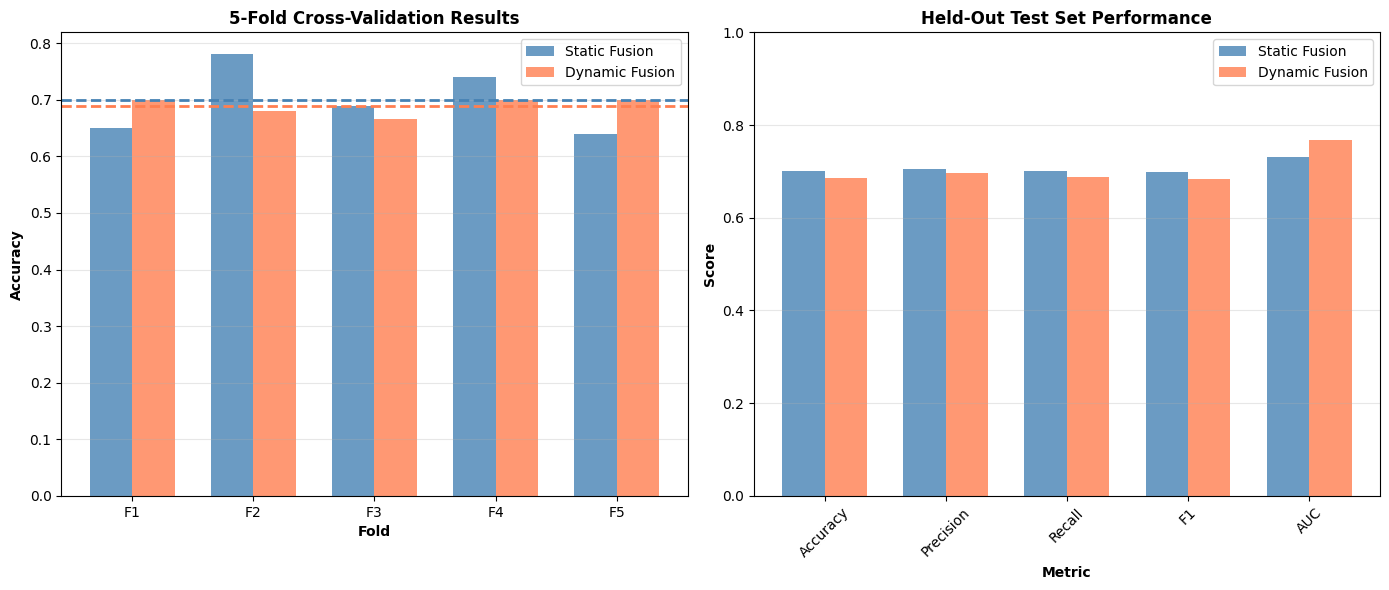

Visualization saved to /content/drive/MyDrive/BagOfLies_Results_Final/final_comparison.png

EXPERIMENT COMPLETE


In [ ]:
# ============================================
# STEP 7: VISUALIZATION
# ============================================

print("\n" + "="*60)
print("CREATING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: CV Results
ax = axes[0]
x = np.arange(5)
width = 0.35
ax.bar(x - width/2, static_accs, width, label='Static Fusion', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_accs, width, label='Dynamic Fusion', color='coral', alpha=0.8)
ax.axhline(np.mean(static_accs), color='steelblue', linestyle='--', linewidth=2)
ax.axhline(np.mean(dynamic_accs), color='coral', linestyle='--', linewidth=2)
ax.set_xlabel('Fold', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('5-Fold Cross-Validation Results', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'F{i+1}' for i in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Final Test Comparison
ax = axes[1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
static_vals = [test_metrics_static[k.lower()] for k in ['accuracy', 'precision', 'recall', 'f1', 'auc']]
dynamic_vals = [test_metrics_dynamic[k.lower()] for k in ['accuracy', 'precision', 'recall', 'f1', 'auc']]

x = np.arange(len(metrics_names))
ax.bar(x - width/2, static_vals, width, label='Static Fusion', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_vals, width, label='Dynamic Fusion', color='coral', alpha=0.8)
ax.set_xlabel('Metric', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Held-Out Test Set Performance', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {RESULTS_DIR}/final_comparison.png")

print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)


# Model 4.0 -> hyperparameters


In [ ]:
# ============================================
# STEP 1: TRAIN/VAL/TEST SPLIT
# ============================================

print("\nSTEP 1: TRAIN/VAL/TEST SPLIT")
print("="*60)

unique_users = np.unique(user_ids)
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

user_labels = np.array([labels[user_to_indices[user][0]] for user in unique_users])

# 80/20 split
train_val_users, test_users = train_test_split(
    unique_users,
    test_size=0.2,
    stratify=user_labels,
    random_state=42
)

test_indices = []
for user in test_users:
    test_indices.extend(user_to_indices[user])

print(f"\nSplit:")
print(f"  Train+Val: {len(train_val_users)} users")
print(f"  Test:      {len(test_users)} users ({len(test_indices)} samples)")
print(f"  Test will remain UNTOUCHED until final evaluation")

# Create CV folds on train+val
train_val_labels = np.array([labels[user_to_indices[user][0]] for user in train_val_users])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_splits = []
for fold_num, (train_idx, val_idx) in enumerate(skf.split(train_val_users, train_val_labels)):
    train_users = train_val_users[train_idx]
    val_users = train_val_users[val_idx]

    train_indices = []
    val_indices = []
    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in val_users:
        val_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train': train_indices,
        'val': val_indices
    })

print(f"\n5-Fold CV setup complete")



STEP 1: TRAIN/VAL/TEST SPLIT

Split:
  Train+Val: 26 users
  Test:      7 users (70 samples)
  Test will remain UNTOUCHED until final evaluation

5-Fold CV setup complete


In [ ]:
# ============================================
# STEP 2: DEFINE HYPERPARAMETER SEARCH SPACE
# ============================================

print("\n" + "="*60)
print("STEP 2: HYPERPARAMETER SEARCH SPACE")
print("="*60)

# Define hyperparameter grid
hyperparam_grid = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2],
    'learning_rate': [5e-4, 1e-3, 2e-3],
    'dropout_fc': [0.3, 0.5],
    'batch_size': [16, 32]
}

# Generate all combinations
from itertools import product

def generate_configs():
    keys = hyperparam_grid.keys()
    values = hyperparam_grid.values()
    configs = []
    for v in product(*values):
        configs.append(dict(zip(keys, v)))
    return configs

all_configs = generate_configs()
print(f"\nTotal hyperparameter combinations: {len(all_configs)}")
print(f"\nExample configurations:")
for i, cfg in enumerate(all_configs[:3]):
    print(f"  {i+1}. {cfg}")

print(f"\nThis would take ~{len(all_configs) * 5 * 15} minutes (too long!)")
print("\nUsing RANDOM SEARCH instead: Testing 10 random configurations")

# Random sample
import random
random.seed(42)
sampled_configs = random.sample(all_configs, min(10, len(all_configs)))

print("\nConfigurations to test:")
for i, cfg in enumerate(sampled_configs):
    print(f"  {i+1}. {cfg}")



STEP 2: HYPERPARAMETER SEARCH SPACE

Total hyperparameter combinations: 72

Example configurations:
  1. {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.3, 'batch_size': 16}
  2. {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.3, 'batch_size': 32}
  3. {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}

This would take ~5400 minutes (too long!)

Using RANDOM SEARCH instead: Testing 10 random configurations

Configurations to test:
  1. {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}
  2. {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 32}
  3. {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
  4. {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.5, 'batch_size': 32}
  5. {'hidden_dim': 128, 'num_layers': 1, 'lear

In [ ]:
# ============================================
# STEP 3: TRAINING FUNCTION FOR HYPERPARAM SEARCH
# ============================================

def train_with_config(model_class, config_dict, fold_splits, text_features, video_features, labels):
    """Train model with given hyperparameters on all folds"""

    fold_scores = []

    for fold_data in fold_splits:
        # Create datasets
        train_ds = TextVideoDataset(text_features, video_features, labels, fold_data['train'])
        val_ds = TextVideoDataset(text_features, video_features, labels, fold_data['val'])

        train_loader = DataLoader(train_ds, batch_size=config_dict['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config_dict['batch_size'], shuffle=False)

        # Create model
        model = model_class(
            text_dim=768,
            video_dim=59,
            hidden_dim=config_dict['hidden_dim'],
            num_layers=config_dict['num_layers']
        ).to(device)

        # Adjust dropout in model (hacky but works)
        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.p = config_dict['dropout_fc']

        # Train
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'], weight_decay=1e-4)

        best_val_acc = 0
        patience = 0
        max_patience = 15

        for epoch in range(100):  # Max 100 epochs
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_metrics = evaluate(model, val_loader, criterion, device)

            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                patience = 0
            else:
                patience += 1

            if patience >= max_patience:
                break

        fold_scores.append(best_val_acc)

        del model
        torch.cuda.empty_cache()

    return np.mean(fold_scores)


In [ ]:
# ============================================
# STEP 4: HYPERPARAMETER SEARCH
# ============================================

print("\n" + "="*60)
print("STEP 3: HYPERPARAMETER SEARCH (5-fold CV)")
print("="*60)

# Search for Static model
print("\n1. STATIC FUSION - Hyperparameter Search")
print("-" * 60)

static_results = []

for i, cfg in enumerate(sampled_configs):
    print(f"\n[{i+1}/{len(sampled_configs)}] Testing: {cfg}")

    avg_score = train_with_config(
        SehrawatExactModel,
        cfg,
        fold_splits,
        text_features,
        video_features_normalized,
        labels
    )

    static_results.append({
        'config': cfg,
        'score': avg_score
    })

    print(f"   Average CV Accuracy: {avg_score:.4f}")

# Find best
best_static = max(static_results, key=lambda x: x['score'])
print(f"\nBest Static Config:")
print(f"  {best_static['config']}")
print(f"  CV Accuracy: {best_static['score']:.4f}")

# Search for Dynamic model
print("\n" + "="*60)
print("2. DYNAMIC FUSION - Hyperparameter Search")
print("-" * 60)

dynamic_results = []

for i, cfg in enumerate(sampled_configs):
    print(f"\n[{i+1}/{len(sampled_configs)}] Testing: {cfg}")

    avg_score = train_with_config(
        DynamicFusionModel,
        cfg,
        fold_splits,
        text_features,
        video_features_normalized,
        labels
    )

    dynamic_results.append({
        'config': cfg,
        'score': avg_score
    })

    print(f"   Average CV Accuracy: {avg_score:.4f}")

# Find best
best_dynamic = max(dynamic_results, key=lambda x: x['score'])
print(f"\nBest Dynamic Config:")
print(f"  {best_dynamic['config']}")
print(f"  CV Accuracy: {best_dynamic['score']:.4f}")




STEP 3: HYPERPARAMETER SEARCH (5-fold CV)

1. STATIC FUSION - Hyperparameter Search
------------------------------------------------------------

[1/10] Testing: {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}
   Average CV Accuracy: 0.6953

[2/10] Testing: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 32}
   Average CV Accuracy: 0.6609

[3/10] Testing: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
   Average CV Accuracy: 0.7142

[4/10] Testing: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.5, 'batch_size': 32}
   Average CV Accuracy: 0.6829

[5/10] Testing: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}
   Average CV Accuracy: 0.7182

[6/10] Testing: {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 32}
   Average

In [ ]:
# ============================================
# STEP 5: RETRAIN WITH BEST HYPERPARAMETERS
# ============================================

print("\n" + "="*60)
print("STEP 4: RETRAIN WITH BEST HYPERPARAMETERS")
print("="*60)

print("\nRetraining both models with best configs on 5-fold CV")

# Retrain Static with best config
print("\n1. Static Fusion with Best Config")
print(f"   Config: {best_static['config']}")

static_cv_results = []

for fold_data in fold_splits:
    fold_num = fold_data['fold']
    print(f"\n   Fold {fold_num}/5")

    cfg = best_static['config']

    train_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['train'])
    val_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['val'])

    train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)

    model = SehrawatExactModel(
        text_dim=768,
        video_dim=59,
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers']
    ).to(device)

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = cfg['dropout_fc']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

    best_val_acc = 0
    patience = 0
    best_metrics = None

    for epoch in range(100):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = evaluate(model, val_loader, criterion, device)

        if (epoch + 1) % 20 == 0:
            print(f"      Epoch {epoch+1}: Val Acc={val_metrics['accuracy']:.4f}")

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience = 0
            best_metrics = val_metrics
        else:
            patience += 1

        if patience >= 15:
            break

    static_cv_results.append(best_metrics)
    print(f"      Best: {best_metrics['accuracy']:.4f}")

    del model
    torch.cuda.empty_cache()

# Retrain Dynamic with best config
print("\n2. Dynamic Fusion with Best Config")
print(f"   Config: {best_dynamic['config']}")

dynamic_cv_results = []

for fold_data in fold_splits:
    fold_num = fold_data['fold']
    print(f"\n   Fold {fold_num}/5")

    cfg = best_dynamic['config']

    train_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['train'])
    val_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['val'])

    train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)

    model = DynamicFusionModel(
        text_dim=768,
        video_dim=59,
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers']
    ).to(device)

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = cfg['dropout_fc']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

    best_val_acc = 0
    patience = 0
    best_metrics = None

    for epoch in range(100):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = evaluate(model, val_loader, criterion, device)

        if (epoch + 1) % 20 == 0:
            print(f"      Epoch {epoch+1}: Val Acc={val_metrics['accuracy']:.4f}")

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience = 0
            best_metrics = val_metrics
        else:
            patience += 1

        if patience >= 15:
            break

    dynamic_cv_results.append(best_metrics)
    print(f"      Best: {best_metrics['accuracy']:.4f}")

    del model
    torch.cuda.empty_cache()

# CV Summary
static_cv_accs = [r['accuracy'] for r in static_cv_results]
dynamic_cv_accs = [r['accuracy'] for r in dynamic_cv_results]

print("\n" + "="*60)
print("CV RESULTS WITH BEST HYPERPARAMETERS")
print("="*60)

print(f"\nStatic Fusion:  {np.mean(static_cv_accs):.4f} +/- {np.std(static_cv_accs):.4f}")
print(f"Dynamic Fusion: {np.mean(dynamic_cv_accs):.4f} +/- {np.std(dynamic_cv_accs):.4f}")



STEP 4: RETRAIN WITH BEST HYPERPARAMETERS

Retraining both models with best configs on 5-fold CV

1. Static Fusion with Best Config
   Config: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}

   Fold 1/5
      Epoch 20: Val Acc=0.6500
      Best: 0.7000

   Fold 2/5
      Epoch 20: Val Acc=0.7200
      Best: 0.7200

   Fold 3/5
      Best: 0.6889

   Fold 4/5
      Best: 0.6800

   Fold 5/5
      Epoch 20: Val Acc=0.6200
      Best: 0.6600

2. Dynamic Fusion with Best Config
   Config: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}

   Fold 1/5
      Epoch 20: Val Acc=0.6333
      Epoch 40: Val Acc=0.5833
      Best: 0.7167

   Fold 2/5
      Epoch 20: Val Acc=0.6400
      Best: 0.6800

   Fold 3/5
      Epoch 20: Val Acc=0.6222
      Best: 0.6889

   Fold 4/5
      Epoch 20: Val Acc=0.6800
      Best: 0.7200

   Fold 5/5
      Epoch 20: Val Acc=0.7400
      Best: 0.7400

CV RESULTS WIT

In [ ]:
# ============================================
# STEP 6: FINAL TEST ON HELD-OUT SET
# ============================================

print("\n" + "="*60)
print("STEP 5: FINAL TEST ON HELD-OUT SET")
print("="*60)

# Get all train+val indices
all_trainval_indices = []
for user in train_val_users:
    all_trainval_indices.extend(user_to_indices[user])

print(f"\nTraining final models on ALL train+val data:")
print(f"  Train+Val samples: {len(all_trainval_indices)}")
print(f"  Test samples: {len(test_indices)}")

final_train_ds = TextVideoDataset(text_features, video_features_normalized, labels, all_trainval_indices)
final_test_ds = TextVideoDataset(text_features, video_features_normalized, labels, test_indices)

# Train final Static model
print("\n1. Training Final Static Model")
cfg = best_static['config']
print(f"   Using: {cfg}")

final_train_loader = DataLoader(final_train_ds, batch_size=cfg['batch_size'], shuffle=True)
final_test_loader = DataLoader(final_test_ds, batch_size=cfg['batch_size'], shuffle=False)

final_static_model = SehrawatExactModel(
    text_dim=768,
    video_dim=59,
    hidden_dim=cfg['hidden_dim'],
    num_layers=cfg['num_layers']
).to(device)

for module in final_static_model.modules():
    if isinstance(module, nn.Dropout):
        module.p = cfg['dropout_fc']

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_static_model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

for epoch in range(50):
    train_loss, train_acc = train_epoch(final_static_model, final_train_loader, criterion, optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"   Epoch {epoch+1}: {train_acc:.4f}")

final_static_test = evaluate(final_static_model, final_test_loader, criterion, device)

# Train final Dynamic model
print("\n2. Training Final Dynamic Model")
cfg = best_dynamic['config']
print(f"   Using: {cfg}")

final_train_loader = DataLoader(final_train_ds, batch_size=cfg['batch_size'], shuffle=True)
final_test_loader = DataLoader(final_test_ds, batch_size=cfg['batch_size'], shuffle=False)

final_dynamic_model = DynamicFusionModel(
    text_dim=768,
    video_dim=59,
    hidden_dim=cfg['hidden_dim'],
    num_layers=cfg['num_layers']
).to(device)

for module in final_dynamic_model.modules():
    if isinstance(module, nn.Dropout):
        module.p = cfg['dropout_fc']

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_dynamic_model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

for epoch in range(50):
    train_loss, train_acc = train_epoch(final_dynamic_model, final_train_loader, criterion, optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"   Epoch {epoch+1}: {train_acc:.4f}")

final_dynamic_test = evaluate(final_dynamic_model, final_test_loader, criterion, device)



STEP 5: FINAL TEST ON HELD-OUT SET

Training final models on ALL train+val data:
  Train+Val samples: 255
  Test samples: 70

1. Training Final Static Model
   Using: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}
   Epoch 10: 0.9765
   Epoch 20: 0.9882
   Epoch 30: 0.9961
   Epoch 40: 0.9804
   Epoch 50: 0.9843

2. Training Final Dynamic Model
   Using: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
   Epoch 10: 0.9882
   Epoch 20: 1.0000
   Epoch 30: 1.0000
   Epoch 40: 1.0000
   Epoch 50: 1.0000


In [ ]:
# ============================================
# STEP 7: FINAL RESULTS
# ============================================

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

print("\nBEST HYPERPARAMETERS FOUND:")
print(f"\nStatic Fusion:")
for k, v in best_static['config'].items():
    print(f"  {k}: {v}")

print(f"\nDynamic Fusion:")
for k, v in best_dynamic['config'].items():
    print(f"  {k}: {v}")

print("\n" + "-"*60)
print("CROSS-VALIDATION RESULTS (with best hyperparams):")
print("-"*60)
print(f"\nStatic Fusion:  {np.mean(static_cv_accs):.4f} +/- {np.std(static_cv_accs):.4f}")
print(f"Dynamic Fusion: {np.mean(dynamic_cv_accs):.4f} +/- {np.std(dynamic_cv_accs):.4f}")

t_stat, p_val = stats.ttest_rel(dynamic_cv_accs, static_cv_accs)
print(f"\nPaired t-test: t={t_stat:.3f}, p={p_val:.4f}")

print("\n" + "-"*60)
print("HELD-OUT TEST SET RESULTS:")
print("-"*60)

print(f"\nStatic Fusion:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"  {metric.capitalize()}: {final_static_test[metric]:.4f}")

print(f"\nDynamic Fusion:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"  {metric.capitalize()}: {final_dynamic_test[metric]:.4f}")

print(f"\nTest Improvement: {(final_dynamic_test['accuracy']-final_static_test['accuracy'])*100:+.2f}%")

print("\n" + "-"*60)
print("COMPARISON TO SEHRAWAT ET AL. (2023):")
print("-"*60)
print(f"  Sehrawat reported:  85.00%")
print(f"  Our static (CV):    {np.mean(static_cv_accs)*100:.2f}%")
print(f"  Our static (test):  {final_static_test['accuracy']*100:.2f}%")
print(f"  Our dynamic (CV):   {np.mean(dynamic_cv_accs)*100:.2f}%")
print(f"  Our dynamic (test): {final_dynamic_test['accuracy']*100:.2f}%")



FINAL RESULTS

BEST HYPERPARAMETERS FOUND:

Static Fusion:
  hidden_dim: 128
  num_layers: 1
  learning_rate: 0.001
  dropout_fc: 0.3
  batch_size: 16

Dynamic Fusion:
  hidden_dim: 64
  num_layers: 1
  learning_rate: 0.002
  dropout_fc: 0.5
  batch_size: 32

------------------------------------------------------------
CROSS-VALIDATION RESULTS (with best hyperparams):
------------------------------------------------------------

Static Fusion:  0.6898 +/- 0.0200
Dynamic Fusion: 0.7091 +/- 0.0218

Paired t-test: t=0.966, p=0.3887

------------------------------------------------------------
HELD-OUT TEST SET RESULTS:
------------------------------------------------------------

Static Fusion:
  Accuracy: 0.7000
  Precision: 0.7145
  Recall: 0.7034
  F1: 0.6970
  Auc: 0.7549

Dynamic Fusion:
  Accuracy: 0.7286
  Precision: 0.7444
  Recall: 0.7247
  F1: 0.7217
  Auc: 0.7312

Test Improvement: +2.86%

------------------------------------------------------------
COMPARISON TO SEHRAWAT ET A

In [ ]:
# ============================================
# STEP 8: SAVE RESULTS
# ============================================

results = {
    'hyperparameter_search': {
        'static_best': best_static,
        'dynamic_best': best_dynamic,
        'static_all_results': static_results,
        'dynamic_all_results': dynamic_results
    },
    'cv_with_best_hyperparams': {
        'static': {
            'accuracies': static_cv_accs,
            'mean': float(np.mean(static_cv_accs)),
            'std': float(np.std(static_cv_accs))
        },
        'dynamic': {
            'accuracies': dynamic_cv_accs,
            'mean': float(np.mean(dynamic_cv_accs)),
            'std': float(np.std(dynamic_cv_accs))
        }
    },
    'final_test': {
        'static': {k: float(v) for k, v in final_static_test.items()},
        'dynamic': {k: float(v) for k, v in final_dynamic_test.items()}
    },
    'statistical_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_val)
    }
}

with open(f'{RESULTS_DIR}/final_results_with_hyperparams.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to {RESULTS_DIR}/final_results_with_hyperparams.json")



Results saved to /content/drive/MyDrive/BagOfLies_Results_Final/final_results_with_hyperparams.json



CREATING VISUALIZATIONS


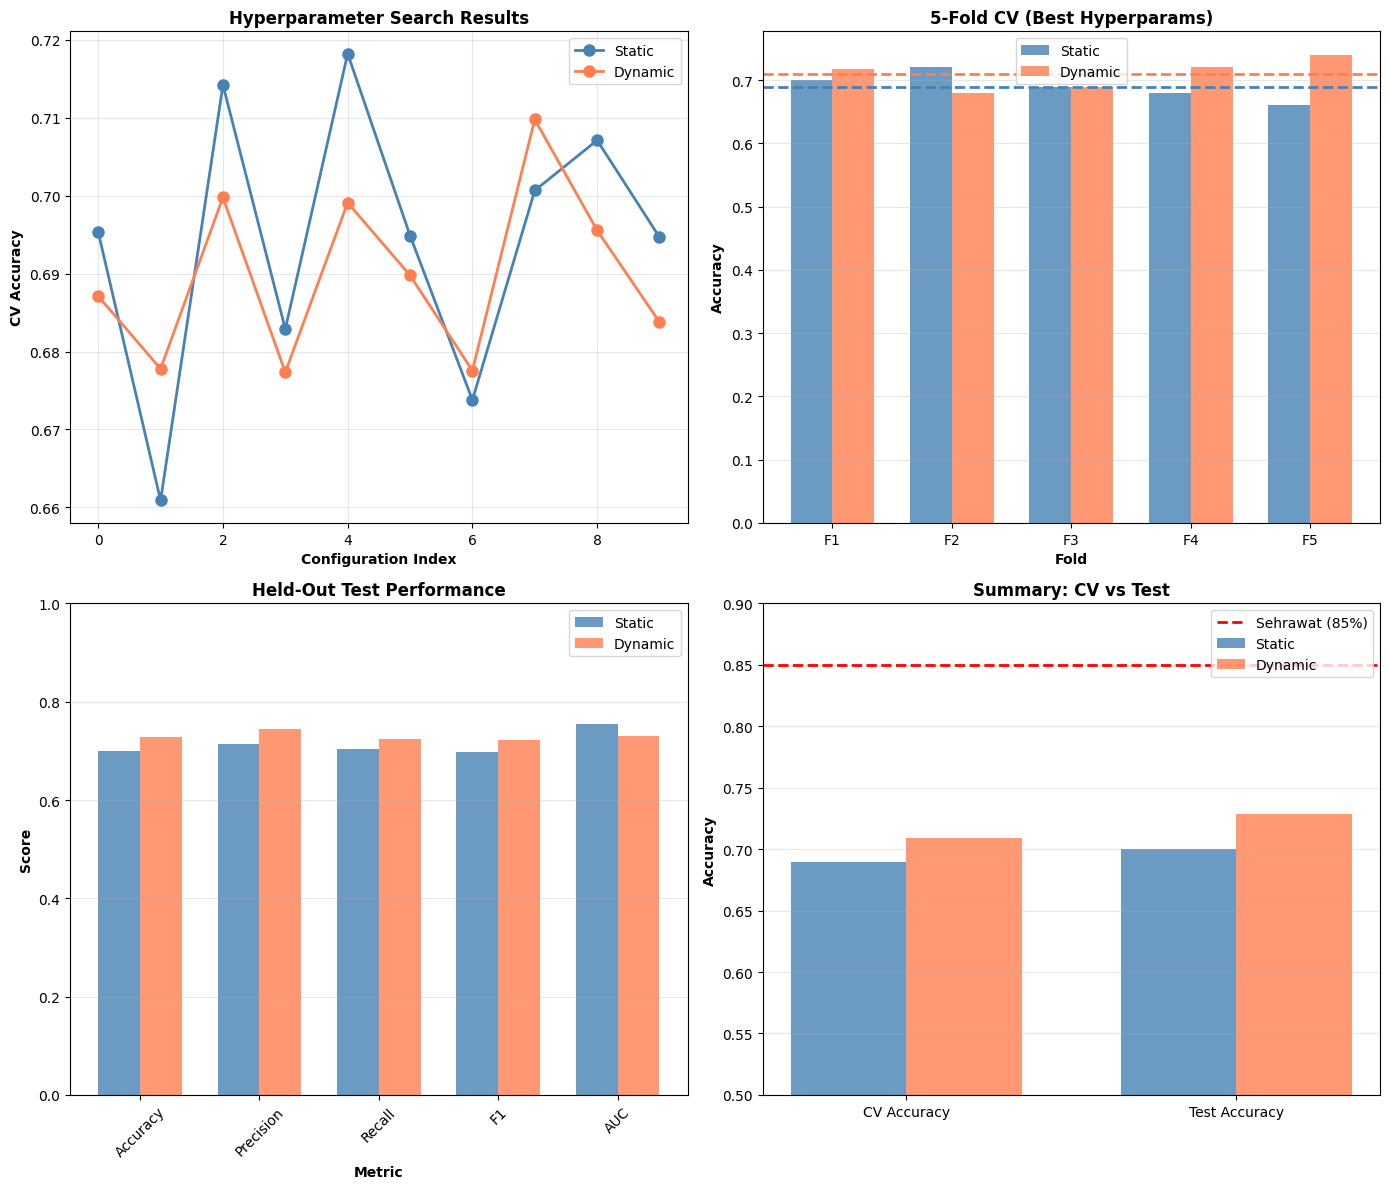

Visualization saved to /content/drive/MyDrive/BagOfLies_Results_Final/complete_results.png

COMPLETE PIPELINE FINISHED


In [ ]:
# ============================================
# STEP 9: VISUALIZATION
# ============================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Hyperparameter search results
ax = axes[0, 0]
static_scores = [r['score'] for r in static_results]
dynamic_scores = [r['score'] for r in dynamic_results]
x = np.arange(len(static_scores))
ax.plot(x, static_scores, 'o-', label='Static', color='steelblue', linewidth=2, markersize=8)
ax.plot(x, dynamic_scores, 'o-', label='Dynamic', color='coral', linewidth=2, markersize=8)
ax.set_xlabel('Configuration Index', fontweight='bold')
ax.set_ylabel('CV Accuracy', fontweight='bold')
ax.set_title('Hyperparameter Search Results', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: CV results with best hyperparams
ax = axes[0, 1]
x = np.arange(5)
width = 0.35
ax.bar(x - width/2, static_cv_accs, width, label='Static', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_cv_accs, width, label='Dynamic', color='coral', alpha=0.8)
ax.axhline(np.mean(static_cv_accs), color='steelblue', linestyle='--', linewidth=2)
ax.axhline(np.mean(dynamic_cv_accs), color='coral', linestyle='--', linewidth=2)
ax.set_xlabel('Fold', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('5-Fold CV (Best Hyperparams)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'F{i+1}' for i in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Final test metrics
ax = axes[1, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
static_vals = [final_static_test[m.lower()] for m in ['accuracy', 'precision', 'recall', 'f1', 'auc']]
dynamic_vals = [final_dynamic_test[m.lower()] for m in ['accuracy', 'precision', 'recall', 'f1', 'auc']]
x = np.arange(len(metrics))
ax.bar(x - width/2, static_vals, width, label='Static', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_vals, width, label='Dynamic', color='coral', alpha=0.8)
ax.set_xlabel('Metric', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Held-Out Test Performance', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Plot 4: Summary comparison
ax = axes[1, 1]
categories = ['CV Accuracy', 'Test Accuracy']
static_summary = [np.mean(static_cv_accs), final_static_test['accuracy']]
dynamic_summary = [np.mean(dynamic_cv_accs), final_dynamic_test['accuracy']]
x = np.arange(len(categories))
ax.bar(x - width/2, static_summary, width, label='Static', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_summary, width, label='Dynamic', color='coral', alpha=0.8)
ax.axhline(0.85, color='red', linestyle='--', linewidth=2, label='Sehrawat (85%)')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Summary: CV vs Test', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.5, 0.9])

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/complete_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {RESULTS_DIR}/complete_results.png")

print("\n" + "="*60)
print("COMPLETE PIPELINE FINISHED")
print("="*60)


In [ ]:
# ============================================
# STEP 1: CREATE 5-FOLD CV (ON ALL DATA)
# ============================================

print("\nSTEP 1: 5-FOLD CROSS-VALIDATION SETUP")
print("="*60)

# Map users to indices
unique_users = np.unique(user_ids)
user_to_indices = {user: [] for user in unique_users}
for idx, user in enumerate(user_ids):
    user_to_indices[user].append(idx)

user_labels = np.array([labels[user_to_indices[user][0]] for user in unique_users])

print(f"\nUsing ALL data:")
print(f"  Total users: {len(unique_users)}")
print(f"  Total samples: {len(labels)}")

# Create 5-fold CV on ALL users
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_splits = []
for fold_num, (train_idx, val_idx) in enumerate(skf.split(unique_users, user_labels)):
    train_users = unique_users[train_idx]
    val_users = unique_users[val_idx]

    train_indices = []
    val_indices = []
    for user in train_users:
        train_indices.extend(user_to_indices[user])
    for user in val_users:
        val_indices.extend(user_to_indices[user])

    fold_splits.append({
        'fold': fold_num + 1,
        'train': train_indices,
        'val': val_indices
    })

    print(f"  Fold {fold_num+1}: Train={len(train_indices)}, Val={len(val_indices)}")

print("\n5-fold CV will use ALL data (no held-out test)")



STEP 1: 5-FOLD CROSS-VALIDATION SETUP

Using ALL data:
  Total users: 33
  Total samples: 325
  Fold 1: Train=260, Val=65
  Fold 2: Train=255, Val=70
  Fold 3: Train=255, Val=70
  Fold 4: Train=265, Val=60
  Fold 5: Train=265, Val=60

5-fold CV will use ALL data (no held-out test)


In [ ]:
# ============================================
# STEP 2: DEFINE HYPERPARAMETER GRID
# ============================================

print("\n" + "="*60)
print("STEP 2: HYPERPARAMETER GRID")
print("="*60)

# Full grid (will test all combinations)
hyperparam_grid = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2],
    'learning_rate': [5e-4, 1e-3, 2e-3],
    'dropout_fc': [0.3, 0.5],
    'batch_size': [16, 32]
}

# Generate all combinations
from itertools import product

keys = hyperparam_grid.keys()
values = hyperparam_grid.values()
all_configs = []
for v in product(*values):
    all_configs.append(dict(zip(keys, v)))

print(f"\nHyperparameter grid:")
for key, vals in hyperparam_grid.items():
    print(f"  {key}: {vals}")

print(f"\nTotal combinations: {len(all_configs)}")
print(f"Estimated time: ~{len(all_configs) * 5 * 10 / 60:.0f} hours")

# Option to subsample if too many
USE_RANDOM_SEARCH = len(all_configs) > 20

if USE_RANDOM_SEARCH:
    print(f"\nToo many combinations! Using random search instead.")
    print(f"Testing {min(20, len(all_configs))} random configurations")
    import random
    random.seed(42)
    sampled_configs = random.sample(all_configs, min(20, len(all_configs)))
else:
    print(f"\nTesting all {len(all_configs)} configurations")
    sampled_configs = all_configs

print(f"\nConfigurations to test:")
for i, cfg in enumerate(sampled_configs[:5]):
    print(f"  {i+1}. {cfg}")
if len(sampled_configs) > 5:
    print(f"  ... and {len(sampled_configs)-5} more")




STEP 2: HYPERPARAMETER GRID

Hyperparameter grid:
  hidden_dim: [64, 128, 256]
  num_layers: [1, 2]
  learning_rate: [0.0005, 0.001, 0.002]
  dropout_fc: [0.3, 0.5]
  batch_size: [16, 32]

Total combinations: 72
Estimated time: ~60 hours

Too many combinations! Using random search instead.
Testing 20 random configurations

Configurations to test:
  1. {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}
  2. {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 32}
  3. {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
  4. {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.5, 'batch_size': 32}
  5. {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}
  ... and 15 more


In [ ]:
# ============================================
# STEP 3: TRAINING FUNCTION FOR ONE CONFIG
# ============================================

def evaluate_config(model_class, config_dict, fold_splits, text_features, video_features, labels):
    """
    Evaluate a hyperparameter configuration using k-fold CV
    Returns mean validation accuracy across all folds
    """
    fold_scores = []

    for fold_data in fold_splits:
        fold_num = fold_data['fold']

        # Create datasets
        train_ds = TextVideoDataset(text_features, video_features, labels, fold_data['train'])
        val_ds = TextVideoDataset(text_features, video_features, labels, fold_data['val'])

        train_loader = DataLoader(train_ds, batch_size=config_dict['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config_dict['batch_size'], shuffle=False)

        # Create model
        model = model_class(
            text_dim=768,
            video_dim=59,
            hidden_dim=config_dict['hidden_dim'],
            num_layers=config_dict['num_layers']
        ).to(device)

        # Adjust dropout
        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.p = config_dict['dropout_fc']

        # Train with early stopping
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'], weight_decay=1e-4)

        best_val_acc = 0
        patience = 0
        max_patience = 15

        for epoch in range(100):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_metrics = evaluate(model, val_loader, criterion, device)

            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                patience = 0
            else:
                patience += 1

            if patience >= max_patience:
                break

        fold_scores.append(best_val_acc)

        del model
        torch.cuda.empty_cache()

    # Return mean and std across folds
    return {
        'mean': np.mean(fold_scores),
        'std': np.std(fold_scores),
        'fold_scores': fold_scores
    }


In [ ]:
# ============================================
# STEP 4: GRID SEARCH FOR STATIC FUSION
# ============================================

print("\n" + "="*60)
print("STEP 3: GRID SEARCH - STATIC FUSION")
print("="*60)

static_grid_results = []

for i, cfg in enumerate(sampled_configs):
    print(f"\n[{i+1}/{len(sampled_configs)}] Testing configuration:")
    print(f"  {cfg}")

    result = evaluate_config(
        SehrawatExactModel,
        cfg,
        fold_splits,
        text_features,
        video_features_normalized,
        labels
    )

    static_grid_results.append({
        'config': cfg,
        'mean_acc': result['mean'],
        'std_acc': result['std'],
        'fold_scores': result['fold_scores']
    })

    print(f"  CV Accuracy: {result['mean']:.4f} +/- {result['std']:.4f}")

# Find best configuration
best_static = max(static_grid_results, key=lambda x: x['mean_acc'])

print("\n" + "="*60)
print("BEST CONFIGURATION FOUND - STATIC FUSION")
print("="*60)
print(f"\nBest hyperparameters:")
for k, v in best_static['config'].items():
    print(f"  {k}: {v}")
print(f"\nCross-validation performance:")
print(f"  Mean accuracy: {best_static['mean_acc']:.4f}")
print(f"  Std deviation: {best_static['std_acc']:.4f}")
print(f"  Fold scores: {[f'{s:.4f}' for s in best_static['fold_scores']]}")



STEP 3: GRID SEARCH - STATIC FUSION

[1/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}
  CV Accuracy: 0.7108 +/- 0.0283

[2/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.6906 +/- 0.0468

[3/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.7112 +/- 0.0419

[4/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.7115 +/- 0.0323

[5/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}
  CV Accuracy: 0.7279 +/- 0.0282

[6/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 32}
  CV Accuracy

In [ ]:
# ============================================
# STEP 5: GRID SEARCH FOR DYNAMIC FUSION
# ============================================

print("\n" + "="*60)
print("STEP 4: GRID SEARCH - DYNAMIC FUSION")
print("="*60)

dynamic_grid_results = []

for i, cfg in enumerate(sampled_configs):
    print(f"\n[{i+1}/{len(sampled_configs)}] Testing configuration:")
    print(f"  {cfg}")

    result = evaluate_config(
        DynamicFusionModel,
        cfg,
        fold_splits,
        text_features,
        video_features_normalized,
        labels
    )

    dynamic_grid_results.append({
        'config': cfg,
        'mean_acc': result['mean'],
        'std_acc': result['std'],
        'fold_scores': result['fold_scores']
    })

    print(f"  CV Accuracy: {result['mean']:.4f} +/- {result['std']:.4f}")

# Find best configuration
best_dynamic = max(dynamic_grid_results, key=lambda x: x['mean_acc'])

print("\n" + "="*60)
print("BEST CONFIGURATION FOUND - DYNAMIC FUSION")
print("="*60)
print(f"\nBest hyperparameters:")
for k, v in best_dynamic['config'].items():
    print(f"  {k}: {v}")
print(f"\nCross-validation performance:")
print(f"  Mean accuracy: {best_dynamic['mean_acc']:.4f}")
print(f"  Std deviation: {best_dynamic['std_acc']:.4f}")
print(f"  Fold scores: {[f'{s:.4f}' for s in best_dynamic['fold_scores']]}")



STEP 4: GRID SEARCH - DYNAMIC FUSION

[1/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 16}
  CV Accuracy: 0.7027 +/- 0.0242

[2/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.6934 +/- 0.0308

[3/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.002, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.7279 +/- 0.0309

[4/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.5, 'batch_size': 32}
  CV Accuracy: 0.7074 +/- 0.0241

[5/20] Testing configuration:
  {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 16}
  CV Accuracy: 0.7188 +/- 0.0443

[6/20] Testing configuration:
  {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.001, 'dropout_fc': 0.3, 'batch_size': 32}
  CV Accurac

In [ ]:
# ============================================
# STEP 6: DETAILED EVALUATION WITH BEST CONFIGS
# ============================================

print("\n" + "="*60)
print("STEP 5: DETAILED EVALUATION WITH BEST CONFIGS")
print("="*60)

print("\nRetraining both models with best hyperparameters for full metrics")

# Retrain Static with best config and collect all metrics
print("\n1. Static Fusion - Detailed Evaluation")
static_detailed_results = []

cfg = best_static['config']

for fold_data in fold_splits:
    fold_num = fold_data['fold']
    print(f"  Fold {fold_num}/5")

    train_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['train'])
    val_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['val'])

    train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)

    model = SehrawatExactModel(
        text_dim=768, video_dim=59,
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers']
    ).to(device)

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = cfg['dropout_fc']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

    best_val_acc = 0
    patience = 0
    best_metrics = None

    for epoch in range(100):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = evaluate(model, val_loader, criterion, device)

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience = 0
            best_metrics = val_metrics
        else:
            patience += 1

        if patience >= 15:
            break

    static_detailed_results.append(best_metrics)
    print(f"    Acc={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, AUC={best_metrics['auc']:.4f}")

    del model
    torch.cuda.empty_cache()

# Retrain Dynamic with best config
print("\n2. Dynamic Fusion - Detailed Evaluation")
dynamic_detailed_results = []

cfg = best_dynamic['config']

for fold_data in fold_splits:
    fold_num = fold_data['fold']
    print(f"  Fold {fold_num}/5")

    train_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['train'])
    val_ds = TextVideoDataset(text_features, video_features_normalized, labels, fold_data['val'])

    train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)

    model = DynamicFusionModel(
        text_dim=768, video_dim=59,
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers']
    ).to(device)

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = cfg['dropout_fc']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-4)

    best_val_acc = 0
    patience = 0
    best_metrics = None

    for epoch in range(100):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = evaluate(model, val_loader, criterion, device)

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience = 0
            best_metrics = val_metrics
        else:
            patience += 1

        if patience >= 15:
            break

    dynamic_detailed_results.append(best_metrics)
    print(f"    Acc={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, AUC={best_metrics['auc']:.4f}")

    del model
    torch.cuda.empty_cache()


In [ ]:
# ============================================
# STEP 7: FINAL RESULTS
# ============================================

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

# Compute statistics
static_accs = [r['accuracy'] for r in static_detailed_results]
static_f1s = [r['f1'] for r in static_detailed_results]
static_aucs = [r['auc'] for r in static_detailed_results]

dynamic_accs = [r['accuracy'] for r in dynamic_detailed_results]
dynamic_f1s = [r['f1'] for r in dynamic_detailed_results]
dynamic_aucs = [r['auc'] for r in dynamic_detailed_results]

print("\n" + "-"*60)
print("BEST HYPERPARAMETERS")
print("-"*60)

print("\nStatic Fusion:")
for k, v in best_static['config'].items():
    print(f"  {k}: {v}")

print("\nDynamic Fusion:")
for k, v in best_dynamic['config'].items():
    print(f"  {k}: {v}")

print("\n" + "-"*60)
print("5-FOLD CROSS-VALIDATION PERFORMANCE")
print("-"*60)

print(f"\nStatic Fusion (Sehrawat-style):")
print(f"  Accuracy:  {np.mean(static_accs):.4f} +/- {np.std(static_accs):.4f}")
print(f"  Precision: {np.mean([r['precision'] for r in static_detailed_results]):.4f}")
print(f"  Recall:    {np.mean([r['recall'] for r in static_detailed_results]):.4f}")
print(f"  F1-Score:  {np.mean(static_f1s):.4f} +/- {np.std(static_f1s):.4f}")
print(f"  AUC-ROC:   {np.mean(static_aucs):.4f} +/- {np.std(static_aucs):.4f}")

print(f"\nDynamic Fusion (Ours):")
print(f"  Accuracy:  {np.mean(dynamic_accs):.4f} +/- {np.std(dynamic_accs):.4f}")
print(f"  Precision: {np.mean([r['precision'] for r in dynamic_detailed_results]):.4f}")
print(f"  Recall:    {np.mean([r['recall'] for r in dynamic_detailed_results]):.4f}")
print(f"  F1-Score:  {np.mean(dynamic_f1s):.4f} +/- {np.std(dynamic_f1s):.4f}")
print(f"  AUC-ROC:   {np.mean(dynamic_aucs):.4f} +/- {np.std(dynamic_aucs):.4f}")

print(f"\nImprovement (Dynamic vs Static):")
print(f"  Accuracy: {(np.mean(dynamic_accs) - np.mean(static_accs))*100:+.2f}%")
print(f"  F1-Score: {(np.mean(dynamic_f1s) - np.mean(static_f1s))*100:+.2f}%")

# Statistical significance
t_stat, p_val = stats.ttest_rel(dynamic_accs, static_accs)
print(f"\nStatistical Test (paired t-test):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_val:.4f}")
if p_val < 0.05:
    print(f"  Result: SIGNIFICANT difference (p < 0.05)")
else:
    print(f"  Result: NOT significant (p >= 0.05)")

print("\n" + "-"*60)
print("COMPARISON TO LITERATURE")
print("-"*60)
print(f"  Sehrawat et al. (2023):  85.00%")
print(f"  Our Static Fusion:       {np.mean(static_accs)*100:.2f}%")
print(f"  Our Dynamic Fusion:      {np.mean(dynamic_accs)*100:.2f}%")


In [ ]:
# ============================================
# STEP 8: SAVE RESULTS
# ============================================

results = {
    'grid_search': {
        'static_all_configs': static_grid_results,
        'dynamic_all_configs': dynamic_grid_results,
        'static_best': best_static,
        'dynamic_best': best_dynamic
    },
    'final_evaluation': {
        'static': {
            'accuracy': {'mean': float(np.mean(static_accs)), 'std': float(np.std(static_accs))},
            'f1': {'mean': float(np.mean(static_f1s)), 'std': float(np.std(static_f1s))},
            'auc': {'mean': float(np.mean(static_aucs)), 'std': float(np.std(static_aucs))},
            'fold_scores': static_accs
        },
        'dynamic': {
            'accuracy': {'mean': float(np.mean(dynamic_accs)), 'std': float(np.std(dynamic_accs))},
            'f1': {'mean': float(np.mean(dynamic_f1s)), 'std': float(np.std(dynamic_f1s))},
            'auc': {'mean': float(np.mean(dynamic_aucs)), 'std': float(np.std(dynamic_aucs))},
            'fold_scores': dynamic_accs
        }
    },
    'statistical_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_val)
    }
}

with open(f'{RESULTS_DIR}/grid_search_results_kfold_only.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to {RESULTS_DIR}/grid_search_results_kfold_only.json")


In [ ]:
# ============================================
# STEP 9: VISUALIZATION
# ============================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Grid search results
ax = axes[0, 0]
static_scores = [r['mean_acc'] for r in static_grid_results]
dynamic_scores = [r['mean_acc'] for r in dynamic_grid_results]
x = np.arange(len(static_scores))
ax.plot(x, static_scores, 'o-', label='Static', color='steelblue', linewidth=2, markersize=8)
ax.plot(x, dynamic_scores, 'o-', label='Dynamic', color='coral', linewidth=2, markersize=8)
ax.axhline(best_static['mean_acc'], color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(best_dynamic['mean_acc'], color='coral', linestyle='--', alpha=0.5)
ax.set_xlabel('Configuration Index', fontweight='bold')
ax.set_ylabel('CV Accuracy', fontweight='bold')
ax.set_title('Hyperparameter Grid Search', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Fold-by-fold comparison
ax = axes[0, 1]
x = np.arange(5)
width = 0.35
ax.bar(x - width/2, static_accs, width, label='Static', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_accs, width, label='Dynamic', color='coral', alpha=0.8)
ax.axhline(np.mean(static_accs), color='steelblue', linestyle='--', linewidth=2)
ax.axhline(np.mean(dynamic_accs), color='coral', linestyle='--', linewidth=2)
ax.set_xlabel('Fold', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('5-Fold CV Results (Best Config)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'F{i+1}' for i in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: All metrics comparison
ax = axes[1, 0]
metrics = ['Accuracy', 'F1-Score', 'AUC-ROC']
static_means = [np.mean(static_accs), np.mean(static_f1s), np.mean(static_aucs)]
dynamic_means = [np.mean(dynamic_accs), np.mean(dynamic_f1s), np.mean(dynamic_aucs)]
x = np.arange(len(metrics))
ax.bar(x - width/2, static_means, width, label='Static', color='steelblue', alpha=0.8)
ax.bar(x + width/2, dynamic_means, width, label='Dynamic', color='coral', alpha=0.8)
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Performance Metrics', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Plot 4: Box plots
ax = axes[1, 1]
bp = ax.boxplot([static_accs, dynamic_accs],
                labels=['Static\nFusion', 'Dynamic\nFusion'],
                patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
for box in bp['boxes']:
    box.set_alpha(0.7)
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Accuracy Distribution', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.plot([1, 2], [np.mean(static_accs), np.mean(dynamic_accs)],
        'D', color='darkred', markersize=10, label='Mean', zorder=3)
ax.legend()

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/grid_search_kfold_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {RESULTS_DIR}/grid_search_kfold_results.png")

print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)
